<a href="https://colab.research.google.com/github/Veewy/2048/blob/master/Master_Thesis_AML_(SAML_D).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌹 **Anti Money Laundering**  🌹     


# 1) Aim of Study 🔍

To evaluate if recurrent neural network (RNN)-style machine learning models, e.g., LSTM are suitable for detecting suspicious financial transactions within the synthetic data, given a significant portion of the fraudulent transactions can be represented as time-series events. This leads to the following main research question (RQ) and 3 sub RQs:

-   *“How effective are LSTM models in detecting money laundering activities within synthetic transaction datasets?”*
---
- RQ 1: Which features are relevant and predictive to the detection of money laundering activities using LSTM models?
---
- RQ 2: How does the performance of LSTM models in detecting AML compare to other machine learning techniques that have been used as benchmarks in previous studies?
---
- RQ 3: What are the challenges and limitations of the LSTM models and how can these be addressed?
---

The findings from this study will be valuable to researchers, AML professionals, financial institutions, and regulatory bodies. By providing insights into the performance of LSTM models in detecting suspicious transactions, the results can help improve fraud detection systems.

# 2) Data Import & Initail Exploration  

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import torch.nn as nn
import torch.optim as optim

from functools import partial
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torch.nn.utils.rnn import pad_sequence #pad the sequences to the same lengt
from sklearn.metrics import f1_score, roc_auc_score
from torchmetrics import F1Score, AUROC
from torch.nn.utils.rnn import pad_sequence # to support batch >1 in dataloader, so need to match the longest sequence in the batch/limit max history length.
from torch.nn.utils.rnn import pack_sequence

In [5]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 33.6 MB/s eta 0:00:00


In [ ]:
# import dataset SAML_D
from google.colab import drive
drive.mount('/content/drive')
df_AML = pd.read_csv('/content/drive/MyDrive/DE/Master_Degree/3rd_Semester/Dataset/SAML-D.csv', sep = ',')

# for easily handling, convert column names to lowercase
df_AML.columns = df_AML.columns.str.lower()
df_AML

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,time,date,sender_account,receiver_account,amount,payment_currency,received_currency,sender_bank_location,receiver_bank_location,payment_type,is_laundering,laundering_type
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
...,...,...,...,...,...,...,...,...,...,...,...,...
9504847,10:57:01,2023-08-23,2453933570,519744068,2247.25,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Small_Fan_Out
9504848,10:57:06,2023-08-23,9805510177,5416607878,927.18,UK pounds,UK pounds,UK,UK,Debit card,0,Normal_Small_Fan_Out
9504849,10:57:06,2023-08-23,7282330957,2995527149,1455.14,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Small_Fan_Out
9504850,10:57:11,2023-08-23,940337377,4812815165,25995.70,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In


In [ ]:
df_AML.head(50)

,time,date,sender_account,receiver_account,amount,payment_currency,received_currency,sender_bank_location,receiver_bank_location,payment_type,is_laundering,laundering_type
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
5,10:35:21,2022-10-07,8974559268,3143547511,5130.99,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Group
6,10:35:23,2022-10-07,980191499,8577635959,12176.52,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Small_Fan_Out
7,10:35:23,2022-10-07,8057793308,9350896213,56.90,UK pounds,UK pounds,UK,UK,Credit card,0,Normal_Small_Fan_Out
8,10:35:26,2022-10-07,6116657264,656192169,4738.45,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Fan_Out
9,10:35:29,2022-10-07,7421451752,2755709071,5883.87,Indian rupee,UK pounds,UK,UK,Credit card,0,Normal_Fan_Out


Features of dataset :

- Time and Date: Essential for tracking transaction chronology.

- Sender and Receiver Account Details: Helps uncover behavioural patterns and complex banking connections.

- Amount: Indicates transaction values to identify suspicious activities.

- Payment Type: Includes various methods like credit card, debit card, cash, ACH transfers, cross-border, and cheque.

- Sender and Receiver Bank Location: Pinpoints high-risk regions including Mexico, Turkey, Morocco, and the UAE.

- Payment and Receiver Currency: Align with location features, adding complexity when mismatched.

- 'Is Suspicious' Feature: Binary indicator differentiating normal from suspicious transactions.

- Type: Classifies typologies, offering deeper insights.

https://www.kaggle.com/datasets/berkanoztas/synthetic-transaction-monitoring-dataset-aml/data

### Prelim. check dataset

In [ ]:
df_AML.info()

# NOTE: ❌ incorrect datatype - for time & date (to be revised)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504852 entries, 0 to 9504851
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   time                    object 
 1   date                    object 
 2   sender_account          int64  
 3   receiver_account        int64  
 4   amount                  float64
 5   payment_currency        object 
 6   received_currency       object 
 7   sender_bank_location    object 
 8   receiver_bank_location  object 
 9   payment_type            object 
 10  is_laundering           int64  
 11  laundering_type         object 
dtypes: float64(1), int64(3), object(8)
memory usage: 870.2+ MB


In [ ]:
df_AML.columns

Index(['time', 'date', 'sender_account', 'receiver_account', 'amount',
       'payment_currency', 'received_currency', 'sender_bank_location',
       'receiver_bank_location', 'payment_type', 'is_laundering',
       'laundering_type'],
      dtype='object')

In [ ]:
df_AML[['is_laundering']].value_counts()

,count
is_laundering,
0,9494979
1,9873


In [ ]:
df_AML.describe()

,sender_account,receiver_account,amount,is_laundering
count,9.504852e+06,9.504852e+06,9.504852e+06,9.504852e+06
mean,5.006619e+09,5.006006e+09,8.762968e+03,1.038733e-03
std,2.885814e+09,2.884763e+09,2.561495e+04,3.221263e-02
min,9.018000e+03,9.018000e+03,3.730000e+00,0.000000e+00
25%,2.513133e+09,2.513219e+09,2.143688e+03,0.000000e+00
50%,5.001017e+09,5.002572e+09,6.113720e+03,0.000000e+00
75%,7.505051e+09,7.502397e+09,1.045846e+04,0.000000e+00
max,9.999987e+09,9.999971e+09,1.261850e+07,1.000000e+00


In [ ]:
df_AML[['sender_account']].value_counts().sort_values(ascending=True)

,count
sender_account,
5005103823,1
571912447,1
572071979,1
572362592,1
572372566,1
...,...
2357599526,749
3831533348,749
5579295130,751


In [ ]:
df_AML[['receiver_account']].value_counts().sort_values(ascending=True)

,count
receiver_account,
9018,1
1064142337,1
4721261368,1
1064093322,1
1064036833,1
...,...
4808614002,737
5579295130,739
5460360634,740


In [ ]:
df_AML[['amount']].value_counts().sort_values(ascending=True)

,count
amount,
12618498.40,1
38309.52,1
44258.11,1
38307.33,1
44261.32,1
...,...
112.76,45
121.53,45
72.39,46


In [ ]:
df_AML[['payment_currency']].value_counts().sort_values(ascending=True)

,count
payment_currency,
Indian rupee,24657
Albanian lek,24778
Mexican Peso,24852
Moroccan dirham,25395
Yen,25562
US dollar,26061
Naira,27143
Pakistani rupee,27196
Dirham,27263


In [ ]:
df_AML[['received_currency']].value_counts().sort_values(ascending=True)

,count
received_currency,
Turkish lira,42545
Dirham,42797
Swiss franc,42931
US dollar,43664
Indian rupee,43757
Naira,45046
Mexican Peso,45255
Albanian lek,45736
Moroccan dirham,45748


In [ ]:
df_AML[['sender_bank_location']].value_counts().sort_values(ascending=True)

,count
sender_bank_location,
Netherlands,16770
India,17596
Albania,17648
Mexico,17662
Austria,18050
Morocco,18437
Japan,18468
France,18702
Italy,18895


In [ ]:
df_AML[['receiver_bank_location']].value_counts().sort_values(ascending=True)

,count
receiver_bank_location,
Turkey,35586
UAE,35897
Switzerland,36081
Italy,36517
USA,36850
India,36936
Spain,37288
Netherlands,37314
Nigeria,38272


In [ ]:
df_AML[['payment_type']].value_counts().sort_values(ascending=True)

,count
payment_type,
Cash Deposit,225206
Cash Withdrawal,300477
Cross-border,933931
ACH,2008807
Cheque,2011419
Debit card,2012103
Credit card,2012909


In [ ]:
df_AML_type = df_AML[['laundering_type']].value_counts().sort_values(ascending=True)
df_AML_type

,count
laundering_type,
Over-Invoicing,54
Fan_Out,237
Single_large,250
Scatter-Gather,338
Behavioural_Change_2,345
Gather-Scatter,354
Fan_In,364
Cycle,382
Bipartite,383


In [ ]:
df_AML[['date']].value_counts().sort_values(ascending=True)

,count
date,
2023-08-23,8400
2022-10-07,20892
2022-10-23,23719
2022-10-30,25298
2022-12-31,25808
...,...
2022-12-23,34156
2023-02-22,34566
2023-02-06,35038


In [ ]:
df_AML1 = df_AML[['receiver_account','is_laundering']]
df_AML1

,receiver_account,is_laundering
0,2769355426,0
1,8401255335,0
2,4404767002,0
3,9600420220,0
4,3803336972,0
...,...,...
9504847,519744068,0
9504848,5416607878,0
9504849,2995527149,0
9504850,4812815165,0


# 3) Data Cleaning

In [ ]:
# handling missing values
df_AML.dropna()

,time,date,sender_account,receiver_account,amount,payment_currency,received_currency,sender_bank_location,receiver_bank_location,payment_type,is_laundering,laundering_type
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
...,...,...,...,...,...,...,...,...,...,...,...,...
9504847,10:57:01,2023-08-23,2453933570,519744068,2247.25,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Small_Fan_Out
9504848,10:57:06,2023-08-23,9805510177,5416607878,927.18,UK pounds,UK pounds,UK,UK,Debit card,0,Normal_Small_Fan_Out
9504849,10:57:06,2023-08-23,7282330957,2995527149,1455.14,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Small_Fan_Out
9504850,10:57:11,2023-08-23,940337377,4812815165,25995.70,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In


In [ ]:
df_AML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504852 entries, 0 to 9504851
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   time                    object 
 1   date                    object 
 2   sender_account          int64  
 3   receiver_account        int64  
 4   amount                  float64
 5   payment_currency        object 
 6   received_currency       object 
 7   sender_bank_location    object 
 8   receiver_bank_location  object 
 9   payment_type            object 
 10  is_laundering           int64  
 11  laundering_type         object 
dtypes: float64(1), int64(3), object(8)
memory usage: 870.2+ MB


In [ ]:
# convert "datetime" datatype
df_AML['date'] = pd.to_datetime(df_AML['date'],format ='%Y-%m-%d')
df_AML['time'] = pd.to_datetime(df_AML['time'],format ='%H:%M:%S')
df_AML

,time,date,sender_account,receiver_account,amount,payment_currency,received_currency,sender_bank_location,receiver_bank_location,payment_type,is_laundering,laundering_type
0,1900-01-01 10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,1900-01-01 10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,1900-01-01 10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,1900-01-01 10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,1900-01-01 10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
...,...,...,...,...,...,...,...,...,...,...,...,...
9504847,1900-01-01 10:57:01,2023-08-23,2453933570,519744068,2247.25,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Small_Fan_Out
9504848,1900-01-01 10:57:06,2023-08-23,9805510177,5416607878,927.18,UK pounds,UK pounds,UK,UK,Debit card,0,Normal_Small_Fan_Out
9504849,1900-01-01 10:57:06,2023-08-23,7282330957,2995527149,1455.14,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Small_Fan_Out
9504850,1900-01-01 10:57:11,2023-08-23,940337377,4812815165,25995.70,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In


In [ ]:
df_AML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504852 entries, 0 to 9504851
Data columns (total 12 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   time                    datetime64[ns]
 1   date                    datetime64[ns]
 2   sender_account          int64         
 3   receiver_account        int64         
 4   amount                  float64       
 5   payment_currency        object        
 6   received_currency       object        
 7   sender_bank_location    object        
 8   receiver_bank_location  object        
 9   payment_type            object        
 10  is_laundering           int64         
 11  laundering_type         object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(6)
memory usage: 870.2+ MB


In [ ]:
# check duplicate rows
df_AML.duplicated().value_counts()

,count
False,9504852


In [ ]:
df_AML.describe()

,time,date,sender_account,receiver_account,amount,is_laundering
count,9504852,9504852,9.504852e+06,9.504852e+06,9.504852e+06,9.504852e+06
mean,1900-01-01 14:41:17.151907840,2023-03-15 21:03:37.048723968,5.006619e+09,5.006006e+09,8.762968e+03,1.038733e-03
min,1900-01-01 00:00:00,2022-10-07 00:00:00,9.018000e+03,9.018000e+03,3.730000e+00,0.000000e+00
25%,1900-01-01 10:33:49,2022-12-27 00:00:00,2.513133e+09,2.513219e+09,2.143688e+03,0.000000e+00
50%,1900-01-01 14:57:49,2023-03-15 00:00:00,5.001017e+09,5.002572e+09,6.113720e+03,0.000000e+00
75%,1900-01-01 19:25:13,2023-06-03 00:00:00,7.505051e+09,7.502397e+09,1.045846e+04,0.000000e+00
max,1900-01-01 23:59:59,2023-08-23 00:00:00,9.999987e+09,9.999971e+09,1.261850e+07,1.000000e+00
std,NaN,NaN,2.885814e+09,2.884763e+09,2.561495e+04,3.221263e-02


In [ ]:
# handling "Nan" Value in Date
df_AML.dropna(subset=['date'])
print(df_AML['date'].isna().sum())

0


In [ ]:
df_AML.dropna(subset=df_AML.columns.values)

,time,date,sender_account,receiver_account,amount,payment_currency,received_currency,sender_bank_location,receiver_bank_location,payment_type,is_laundering,laundering_type
0,1900-01-01 10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,1900-01-01 10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,1900-01-01 10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,1900-01-01 10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,1900-01-01 10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
...,...,...,...,...,...,...,...,...,...,...,...,...
9504847,1900-01-01 10:57:01,2023-08-23,2453933570,519744068,2247.25,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Small_Fan_Out
9504848,1900-01-01 10:57:06,2023-08-23,9805510177,5416607878,927.18,UK pounds,UK pounds,UK,UK,Debit card,0,Normal_Small_Fan_Out
9504849,1900-01-01 10:57:06,2023-08-23,7282330957,2995527149,1455.14,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Small_Fan_Out
9504850,1900-01-01 10:57:11,2023-08-23,940337377,4812815165,25995.70,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In


# 4) Data Transformation &  Exploratory Data Analysis (EDA)

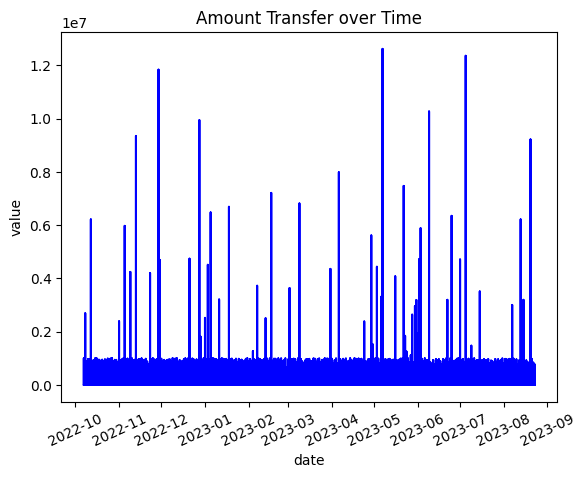

In [ ]:
# check trend over time

plt.plot(df_AML['date'],df_AML['amount'],  color='blue')
plt.xlabel('date')
plt.ylabel('value')
plt.title('Amount Transfer over Time')
plt.xticks(rotation =25)

plt.show()

In [ ]:
df_AML.columns

Index(['time', 'date', 'sender_account', 'receiver_account', 'amount',
       'payment_currency', 'received_currency', 'sender_bank_location',
       'receiver_bank_location', 'payment_type', 'is_laundering',
       'laundering_type'],
      dtype='object')

In [ ]:
#check unique a/c per person (as receiver and sender)

df_AML['receiver_account'].nunique()

652266

In [ ]:
df_AML['sender_account'].nunique()

292715

In [ ]:
652266+292717

944983

In [ ]:
#check all unique a/c (as one a/c can be both receiver and sender)
unique_accounts = pd.concat([df_AML['receiver_account'],df_AML['sender_account']]).nunique()

unique_accounts

855460

In [ ]:
# redundant a/c = total unique sender + total unique receiver  - total unique a.c. both sender& receiver
944983-855460

89523

In [ ]:
# show distribution of each unique a/c
pd.concat([df_AML['sender_account'], df_AML['receiver_account']]).value_counts()

,count
2938210715,1498
4808614002,1491
5579295130,1490
8600542721,1489
2357599526,1481
...,...
5231099554,1
2052695205,1
1131087357,1
6664811998,1


### Encoding Categorical Variables   
(e.g. currency, bank location, payment type, launderting type, date and time )

In [ ]:
df_AML.columns

Index(['time', 'date', 'sender_account', 'receiver_account', 'amount',
       'payment_currency', 'received_currency', 'sender_bank_location',
       'receiver_bank_location', 'payment_type', 'is_laundering',
       'laundering_type'],
      dtype='object')

In [ ]:
#lable encoder for (i) currency, (ii) bank location, (iii) laundering type
label_encoder = LabelEncoder()
df_AML['payment_currency_encoded'] = label_encoder.fit_transform(df_AML['payment_currency'])
df_AML['received_currency_encoded'] = label_encoder.fit_transform(df_AML['received_currency'])
df_AML['sender_bank_location_encoded'] = label_encoder.fit_transform(df_AML['sender_bank_location'])
df_AML['receiver_bank_location_encoded'] = label_encoder.fit_transform(df_AML['receiver_bank_location'])
df_AML['laundering_type_encoded'] = label_encoder.fit_transform(df_AML['laundering_type'])

df_AML

,time,date,sender_account,receiver_account,amount,payment_currency,received_currency,sender_bank_location,receiver_bank_location,payment_type,is_laundering,laundering_type,payment_currency_encoded,received_currency_encoded,sender_bank_location_encoded,receiver_bank_location_encoded,laundering_type_encoded
0,1900-01-01 10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits,10,10,16,16,11
1,1900-01-01 10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out,10,1,16,15,14
2,1900-01-01 10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out,10,10,16,16,20
3,1900-01-01 10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In,10,10,16,16,13
4,1900-01-01 10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits,10,10,16,16,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9504847,1900-01-01 10:57:01,2023-08-23,2453933570,519744068,2247.25,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Small_Fan_Out,10,10,16,16,20
9504848,1900-01-01 10:57:06,2023-08-23,9805510177,5416607878,927.18,UK pounds,UK pounds,UK,UK,Debit card,0,Normal_Small_Fan_Out,10,10,16,16,20
9504849,1900-01-01 10:57:06,2023-08-23,7282330957,2995527149,1455.14,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Small_Fan_Out,10,10,16,16,20
9504850,1900-01-01 10:57:11,2023-08-23,940337377,4812815165,25995.70,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In,10,10,16,16,13


In [ ]:
# mapping label encoder with original label (as for reference)  # reset index to convert to a DataFrame
df_AML[['payment_currency', 'payment_currency_encoded']].value_counts().reset_index(name='count')\
                                                        .sort_values(by='payment_currency_encoded', ascending=True)

,payment_currency,payment_currency_encoded,count
11,Albanian lek,0,24778
4,Dirham,1,27263
1,Euro,2,117164
12,Indian rupee,3,24657
10,Mexican Peso,4,24852
9,Moroccan dirham,5,25395
6,Naira,6,27143
5,Pakistani rupee,7,27196
3,Swiss franc,8,27492
2,Turkish lira,9,27996


In [ ]:
df_AML[['received_currency', 'received_currency_encoded']].value_counts().reset_index(name='count')\
                                                        .sort_values(by='received_currency_encoded', ascending=True)

,received_currency,received_currency_encoded,count
5,Albanian lek,0,45736
11,Dirham,1,42797
1,Euro,2,231911
8,Indian rupee,3,43757
6,Mexican Peso,4,45255
4,Moroccan dirham,5,45748
7,Naira,6,45046
2,Pakistani rupee,7,45993
10,Swiss franc,8,42931
12,Turkish lira,9,42545


In [ ]:
df_AML[['receiver_bank_location', 'receiver_bank_location_encoded']].value_counts().reset_index(name='count')\
                                                        .sort_values(by='receiver_bank_location_encoded', ascending=True)

,receiver_bank_location,receiver_bank_location_encoded,count
3,Albania,0,38783
2,Austria,1,38844
7,France,2,38512
6,Germany,3,38540
12,India,4,36936
14,Italy,5,36517
4,Japan,6,38729
8,Mexico,7,38385
5,Morocco,8,38704
10,Netherlands,9,37314


In [ ]:
df_AML[['sender_bank_location', 'sender_bank_location_encoded']].value_counts().reset_index(name='count')\
                                                        .sort_values(by='sender_bank_location_encoded', ascending=True)

,sender_bank_location,sender_bank_location_encoded,count
15,Albania,0,17648
13,Austria,1,18050
10,France,2,18702
7,Germany,3,19259
16,India,4,17596
9,Italy,5,18895
11,Japan,6,18468
14,Mexico,7,17662
12,Morocco,8,18437
17,Netherlands,9,16770


In [ ]:
df_AML[['laundering_type', 'laundering_type_encoded']].value_counts().reset_index()\
                                                      .sort_values(by='laundering_type_encoded',ascending=True)

,laundering_type,laundering_type_encoded,count
18,Behavioural_Change_1,0,394
23,Behavioural_Change_2,1,345
19,Bipartite,2,383
12,Cash_Withdrawal,3,1334
20,Cycle,4,382
13,Deposit-Send,5,945
21,Fan_In,6,364
26,Fan_Out,7,237
22,Gather-Scatter,8,354
15,Layered_Fan_In,9,656


In [ ]:
# convert "date" to "day_of_week" and map to integer
df_AML['day_of_week'] = df_AML['date'].dt.day_name()

day_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
df_AML['day_of_week_encoded'] = df_AML['day_of_week'].map(day_mapping)
df_AML

,time,date,sender_account,receiver_account,amount,payment_currency,received_currency,sender_bank_location,receiver_bank_location,payment_type,is_laundering,laundering_type,payment_currency_encoded,received_currency_encoded,sender_bank_location_encoded,receiver_bank_location_encoded,laundering_type_encoded,day_of_week,day_of_week_encoded
0,1900-01-01 10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits,10,10,16,16,11,Friday,4
1,1900-01-01 10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out,10,1,16,15,14,Friday,4
2,1900-01-01 10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out,10,10,16,16,20,Friday,4
3,1900-01-01 10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In,10,10,16,16,13,Friday,4
4,1900-01-01 10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits,10,10,16,16,11,Friday,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9504847,1900-01-01 10:57:01,2023-08-23,2453933570,519744068,2247.25,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Small_Fan_Out,10,10,16,16,20,Wednesday,2
9504848,1900-01-01 10:57:06,2023-08-23,9805510177,5416607878,927.18,UK pounds,UK pounds,UK,UK,Debit card,0,Normal_Small_Fan_Out,10,10,16,16,20,Wednesday,2
9504849,1900-01-01 10:57:06,2023-08-23,7282330957,2995527149,1455.14,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Small_Fan_Out,10,10,16,16,20,Wednesday,2
9504850,1900-01-01 10:57:11,2023-08-23,940337377,4812815165,25995.70,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In,10,10,16,16,13,Wednesday,2


In [ ]:
df_AML[['day_of_week', 'day_of_week_encoded']].value_counts()\
                                              .reset_index().sort_values(by='day_of_week_encoded',ascending=True)

,day_of_week,day_of_week_encoded,count
0,Monday,0,1389246
2,Tuesday,1,1369343
3,Wednesday,2,1366034
4,Thursday,3,1350706
1,Friday,4,1369872
5,Saturday,5,1336623
6,Sunday,6,1323028


In [ ]:
# create 'hour' feature
df_AML['hour'] = df_AML['time'].dt.hour

df_AML.head()

,time,date,sender_account,receiver_account,amount,payment_currency,received_currency,sender_bank_location,receiver_bank_location,payment_type,is_laundering,laundering_type,payment_currency_encoded,received_currency_encoded,sender_bank_location_encoded,receiver_bank_location_encoded,laundering_type_encoded,day_of_week,day_of_week_encoded,hour
0,1900-01-01 10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits,10,10,16,16,11,Friday,4,10
1,1900-01-01 10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out,10,1,16,15,14,Friday,4,10
2,1900-01-01 10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out,10,10,16,16,20,Friday,4,10
3,1900-01-01 10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In,10,10,16,16,13,Friday,4,10
4,1900-01-01 10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits,10,10,16,16,11,Friday,4,10


In [ ]:
df_AML[['hour']].value_counts(). reset_index().sort_values(by='hour', ascending=True)

,hour,count
21,0,121548
18,1,121964
19,2,121627
23,3,121282
20,4,121568
17,5,122114
22,6,121484
16,7,142497
8,8,538992
7,9,539044


In [ ]:
df_AML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504852 entries, 0 to 9504851
Data columns (total 20 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   time                            datetime64[ns]
 1   date                            datetime64[ns]
 2   sender_account                  int64         
 3   receiver_account                int64         
 4   amount                          float64       
 5   payment_currency                object        
 6   received_currency               object        
 7   sender_bank_location            object        
 8   receiver_bank_location          object        
 9   payment_type                    object        
 10  is_laundering                   int64         
 11  laundering_type                 object        
 12  payment_currency_encoded        int64         
 13  received_currency_encoded       int64         
 14  sender_bank_location_encoded    int64         
 15

In [ ]:
#convert 'time' to 'time of day' by extracting hour & define it as Morning(5.00-11.59), Afternoon(12.00-16.59), Evening(17.00-20.59) or Night(21.00-4.59)

def define_time_of_day(t):
    hour = t.hour

    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    else:
        return "Night"

df_AML['time_of_day'] = df_AML['time'].apply(define_time_of_day)

df_AML.head()

,time,date,sender_account,receiver_account,amount,payment_currency,received_currency,sender_bank_location,receiver_bank_location,payment_type,...,laundering_type,payment_currency_encoded,received_currency_encoded,sender_bank_location_encoded,receiver_bank_location_encoded,laundering_type_encoded,day_of_week,day_of_week_encoded,hour,time_of_day
0,1900-01-01 10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,...,Normal_Cash_Deposits,10,10,16,16,11,Friday,4,10,Morning
1,1900-01-01 10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,...,Normal_Fan_Out,10,1,16,15,14,Friday,4,10,Morning
2,1900-01-01 10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,...,Normal_Small_Fan_Out,10,10,16,16,20,Friday,4,10,Morning
3,1900-01-01 10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,...,Normal_Fan_In,10,10,16,16,13,Friday,4,10,Morning
4,1900-01-01 10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,...,Normal_Cash_Deposits,10,10,16,16,11,Friday,4,10,Morning


In [ ]:
# map 'time of day' to integer
time_mapping = {'Morning': 0, 'Afternoon': 1, 'Evening': 2, 'Night': 3}
df_AML['time_of_day_encoded'] = df_AML['time_of_day'].map(time_mapping)
df_AML.head()


,time,date,sender_account,receiver_account,amount,payment_currency,received_currency,sender_bank_location,receiver_bank_location,payment_type,...,payment_currency_encoded,received_currency_encoded,sender_bank_location_encoded,receiver_bank_location_encoded,laundering_type_encoded,day_of_week,day_of_week_encoded,hour,time_of_day,time_of_day_encoded
0,1900-01-01 10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,...,10,10,16,16,11,Friday,4,10,Morning,0
1,1900-01-01 10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,...,10,1,16,15,14,Friday,4,10,Morning,0
2,1900-01-01 10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,...,10,10,16,16,20,Friday,4,10,Morning,0
3,1900-01-01 10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,...,10,10,16,16,13,Friday,4,10,Morning,0
4,1900-01-01 10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,...,10,10,16,16,11,Friday,4,10,Morning,0


In [ ]:
df_AML[['time_of_day', 'time_of_day_encoded']].value_counts()\
                                              .reset_index().sort_values(by='time_of_day_encoded',ascending=True)

,time_of_day,time_of_day_encoded,count
1,Morning,0,2543974
0,Afternoon,1,2699060
3,Evening,2,2096427
2,Night,3,2165391


In [ ]:
df_AML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504852 entries, 0 to 9504851
Data columns (total 22 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   time                            datetime64[ns]
 1   date                            datetime64[ns]
 2   sender_account                  int64         
 3   receiver_account                int64         
 4   amount                          float64       
 5   payment_currency                object        
 6   received_currency               object        
 7   sender_bank_location            object        
 8   receiver_bank_location          object        
 9   payment_type                    object        
 10  is_laundering                   int64         
 11  laundering_type                 object        
 12  payment_currency_encoded        int64         
 13  received_currency_encoded       int64         
 14  sender_bank_location_encoded    int64         
 15

# 5) Feature Engineering and Feature Selection

### Create new DataFrame with chronological transaction flows for each unique account ID

In [ ]:
# create DataFrames for unique account with chronological flow (both sender & receiver)

df_sender = df_AML[['sender_account','time', 'date', 'amount','is_laundering','payment_currency_encoded',\
                    'received_currency_encoded','sender_bank_location_encoded','receiver_bank_location_encoded',\
                    'laundering_type_encoded','day_of_week_encoded','hour','time_of_day_encoded','receiver_account']].copy()
df_sender = df_sender.rename(columns={'sender_account': 'account'})
df_sender['transaction_type'] = 'sent'

df_sender = df_sender.rename(columns={'receiver_account':'account_interaction'})

df_sender = df_sender.sort_values(by=['account', 'date','time'])
df_sender


,account,time,date,amount,is_laundering,payment_currency_encoded,received_currency_encoded,sender_bank_location_encoded,receiver_bank_location_encoded,laundering_type_encoded,day_of_week_encoded,hour,time_of_day_encoded,account_interaction,transaction_type
8572082,9018,1900-01-01 09:51:28,2023-07-22,3319.06,0,10,2,16,3,15,5,9,0,2388293593,sent
3210514,28511,1900-01-01 23:28:15,2023-01-24,6371.25,0,10,10,16,16,19,1,23,3,3072405466,sent
4191567,28511,1900-01-01 23:31:38,2023-02-24,3878.00,0,10,10,16,16,19,4,23,3,3072405466,sent
5018226,28511,1900-01-01 20:51:59,2023-03-24,4109.92,0,10,10,16,16,19,4,20,2,3072405466,sent
5938108,28511,1900-01-01 19:38:10,2023-04-24,7147.58,0,10,10,16,16,19,0,19,2,3072405466,sent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7483420,9999986843,1900-01-01 18:33:08,2023-06-15,6634.60,0,10,10,16,16,13,3,18,2,2812722257,sent
7485577,9999986843,1900-01-01 19:46:17,2023-06-15,6667.48,0,10,10,16,16,13,3,19,2,2812722257,sent
7487475,9999986843,1900-01-01 20:48:31,2023-06-15,6671.73,0,10,10,16,16,13,3,20,2,2812722257,sent
7488709,9999986843,1900-01-01 21:29:01,2023-06-15,6633.19,0,10,10,16,16,13,3,21,3,2812722257,sent


In [ ]:
df_receiver = df_AML[['receiver_account','time', 'date', 'amount','is_laundering','payment_currency_encoded',\
                    'received_currency_encoded','sender_bank_location_encoded','receiver_bank_location_encoded',\
                    'laundering_type_encoded','day_of_week_encoded','hour','time_of_day_encoded','sender_account']].copy()
df_receiver = df_receiver.rename(columns={'receiver_account': 'account'})
df_receiver['transaction_type'] = 'received'

df_receiver = df_receiver.rename(columns={'sender_account': 'account_interaction'})

df_receiver = df_receiver.sort_values(by=['account','date', 'time'])
df_receiver


,account,time,date,amount,is_laundering,payment_currency_encoded,received_currency_encoded,sender_bank_location_encoded,receiver_bank_location_encoded,laundering_type_encoded,day_of_week_encoded,hour,time_of_day_encoded,account_interaction,transaction_type
8562799,9018,1900-01-01 21:32:35,2023-07-21,3319.06,0,10,10,16,16,15,4,21,3,6080420349,received
1420882,13266,1900-01-01 16:20:16,2022-11-24,1178.70,0,10,10,16,16,20,3,16,1,2595228252,received
1753672,13266,1900-01-01 04:28:33,2022-12-06,2218.12,0,10,10,16,16,20,1,4,3,2595228252,received
2850709,13266,1900-01-01 19:44:39,2023-01-12,594.97,0,10,10,16,16,20,3,19,2,2595228252,received
3186386,13266,1900-01-01 09:13:08,2023-01-24,1043.72,0,10,10,16,16,20,1,9,0,2595228252,received
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6200086,9999971095,1900-01-01 11:45:46,2023-05-03,4607.86,0,10,10,16,16,20,2,11,0,7267454854,received
8235911,9999971095,1900-01-01 21:17:42,2023-07-10,5033.27,0,10,10,16,16,20,0,21,3,7267454854,received
8669286,9999971095,1900-01-01 20:28:23,2023-07-25,4755.19,0,10,4,16,16,20,1,20,2,7267454854,received
8799403,9999971095,1900-01-01 10:29:42,2023-07-30,4323.83,0,10,10,16,16,20,6,10,0,7267454854,received


In [ ]:
#combine chronologically by account of above 2 new DataFrames together

df_combined_accounts = pd.concat([df_sender, df_receiver], ignore_index=True)
df_combined_accounts = df_combined_accounts.sort_values(by=['account','date', 'time'])
df_combined_accounts

,account,time,date,amount,is_laundering,payment_currency_encoded,received_currency_encoded,sender_bank_location_encoded,receiver_bank_location_encoded,laundering_type_encoded,day_of_week_encoded,hour,time_of_day_encoded,account_interaction,transaction_type
9504852,9018,1900-01-01 21:32:35,2023-07-21,3319.06,0,10,10,16,16,15,4,21,3,6080420349,received
0,9018,1900-01-01 09:51:28,2023-07-22,3319.06,0,10,2,16,3,15,5,9,0,2388293593,sent
9504853,13266,1900-01-01 16:20:16,2022-11-24,1178.70,0,10,10,16,16,20,3,16,1,2595228252,received
9504854,13266,1900-01-01 04:28:33,2022-12-06,2218.12,0,10,10,16,16,20,1,4,3,2595228252,received
9504855,13266,1900-01-01 19:44:39,2023-01-12,594.97,0,10,10,16,16,20,3,19,2,2595228252,received
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9504847,9999986843,1900-01-01 18:33:08,2023-06-15,6634.60,0,10,10,16,16,13,3,18,2,2812722257,sent
9504848,9999986843,1900-01-01 19:46:17,2023-06-15,6667.48,0,10,10,16,16,13,3,19,2,2812722257,sent
9504849,9999986843,1900-01-01 20:48:31,2023-06-15,6671.73,0,10,10,16,16,13,3,20,2,2812722257,sent
9504850,9999986843,1900-01-01 21:29:01,2023-06-15,6633.19,0,10,10,16,16,13,3,21,3,2812722257,sent


In [ ]:
df_combined_accounts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19009704 entries, 9504852 to 9504851
Data columns (total 15 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   account                         int64         
 1   time                            datetime64[ns]
 2   date                            datetime64[ns]
 3   amount                          float64       
 4   is_laundering                   int64         
 5   payment_currency_encoded        int64         
 6   received_currency_encoded       int64         
 7   sender_bank_location_encoded    int64         
 8   receiver_bank_location_encoded  int64         
 9   laundering_type_encoded         int64         
 10  day_of_week_encoded             int64         
 11  hour                            int32         
 12  time_of_day_encoded             int64         
 13  account_interaction             int64         
 14  transaction_type                object        
d

In [ ]:
df_combined_accounts.describe()

,account,time,date,amount,is_laundering,payment_currency_encoded,received_currency_encoded,sender_bank_location_encoded,receiver_bank_location_encoded,laundering_type_encoded,day_of_week_encoded,hour,time_of_day_encoded,account_interaction
count,1.900970e+07,19009704,19009704,1.900970e+07,1.900970e+07,1.900970e+07,1.900970e+07,1.900970e+07,1.900970e+07,1.900970e+07,1.900970e+07,1.900970e+07,1.900970e+07,1.900970e+07
mean,5.006313e+09,1900-01-01 14:41:17.151905024,2023-03-15 21:03:37.048724224,8.762968e+03,1.038733e-03,9.781680e+00,9.598556e+00,1.573733e+01,1.545880e+01,1.617889e+01,2.972619e+00,1.418820e+01,1.408553e+00,5.006313e+09
min,9.018000e+03,1900-01-01 00:00:00,2022-10-07 00:00:00,3.730000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.018000e+03
25%,2.513133e+09,1900-01-01 10:33:49,2022-12-27 00:00:00,2.143688e+03,0.000000e+00,1.000000e+01,1.000000e+01,1.600000e+01,1.600000e+01,1.300000e+01,1.000000e+00,1.000000e+01,0.000000e+00,2.513133e+09
50%,5.001695e+09,1900-01-01 14:57:49,2023-03-15 00:00:00,6.113720e+03,0.000000e+00,1.000000e+01,1.000000e+01,1.600000e+01,1.600000e+01,1.400000e+01,3.000000e+00,1.400000e+01,1.000000e+00,5.001695e+09
75%,7.503758e+09,1900-01-01 19:25:13,2023-06-03 00:00:00,1.045846e+04,0.000000e+00,1.000000e+01,1.000000e+01,1.600000e+01,1.600000e+01,2.000000e+01,5.000000e+00,1.900000e+01,2.000000e+00,7.503758e+09
max,9.999987e+09,1900-01-01 23:59:59,2023-08-23 00:00:00,1.261850e+07,1.000000e+00,1.200000e+01,1.200000e+01,1.700000e+01,1.700000e+01,2.700000e+01,6.000000e+00,2.300000e+01,3.000000e+00,9.999987e+09
std,2.885288e+09,NaN,NaN,2.561495e+04,3.221263e-02,1.273485e+00,1.711549e+00,1.678859e+00,2.393672e+00,3.211784e+00,1.998519e+00,5.714591e+00,1.110215e+00,2.885288e+09


In [ ]:
df_combined_accounts.duplicated().value_counts()

,count
False,19009704


### Calculate the time interval between each transaction in the flow for each account ID

In [ ]:
#combine date+time together before finding 'time interval' for each a/c

df_combined_accounts['time2'] = df_combined_accounts['time'].dt.time #delete default date '1900-01-01' in 'time'

df_combined_accounts['datetime'] = df_combined_accounts['date'].astype(str) + ' ' + df_combined_accounts['time2'].astype(str)

df_combined_accounts['datetime'] = pd.to_datetime(df_combined_accounts['datetime'], format='%Y-%m-%d %H:%M:%S')
df_combined_accounts

,account,time,date,amount,is_laundering,payment_currency_encoded,received_currency_encoded,sender_bank_location_encoded,receiver_bank_location_encoded,laundering_type_encoded,day_of_week_encoded,hour,time_of_day_encoded,account_interaction,transaction_type,time2,datetime
9504852,9018,1900-01-01 21:32:35,2023-07-21,3319.06,0,10,10,16,16,15,4,21,3,6080420349,received,21:32:35,2023-07-21 21:32:35
0,9018,1900-01-01 09:51:28,2023-07-22,3319.06,0,10,2,16,3,15,5,9,0,2388293593,sent,09:51:28,2023-07-22 09:51:28
9504853,13266,1900-01-01 16:20:16,2022-11-24,1178.70,0,10,10,16,16,20,3,16,1,2595228252,received,16:20:16,2022-11-24 16:20:16
9504854,13266,1900-01-01 04:28:33,2022-12-06,2218.12,0,10,10,16,16,20,1,4,3,2595228252,received,04:28:33,2022-12-06 04:28:33
9504855,13266,1900-01-01 19:44:39,2023-01-12,594.97,0,10,10,16,16,20,3,19,2,2595228252,received,19:44:39,2023-01-12 19:44:39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9504847,9999986843,1900-01-01 18:33:08,2023-06-15,6634.60,0,10,10,16,16,13,3,18,2,2812722257,sent,18:33:08,2023-06-15 18:33:08
9504848,9999986843,1900-01-01 19:46:17,2023-06-15,6667.48,0,10,10,16,16,13,3,19,2,2812722257,sent,19:46:17,2023-06-15 19:46:17
9504849,9999986843,1900-01-01 20:48:31,2023-06-15,6671.73,0,10,10,16,16,13,3,20,2,2812722257,sent,20:48:31,2023-06-15 20:48:31
9504850,9999986843,1900-01-01 21:29:01,2023-06-15,6633.19,0,10,10,16,16,13,3,21,3,2812722257,sent,21:29:01,2023-06-15 21:29:01


In [ ]:
df_combined_accounts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19009704 entries, 9504852 to 9504851
Data columns (total 17 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   account                         int64         
 1   time                            datetime64[ns]
 2   date                            datetime64[ns]
 3   amount                          float64       
 4   is_laundering                   int64         
 5   payment_currency_encoded        int64         
 6   received_currency_encoded       int64         
 7   sender_bank_location_encoded    int64         
 8   receiver_bank_location_encoded  int64         
 9   laundering_type_encoded         int64         
 10  day_of_week_encoded             int64         
 11  hour                            int32         
 12  time_of_day_encoded             int64         
 13  account_interaction             int64         
 14  transaction_type                object        
 

In [ ]:
df_combined_accounts['time_interval'] = df_combined_accounts.groupby('account')['datetime'].diff()

df_combined_accounts.head()

,account,time,date,amount,is_laundering,payment_currency_encoded,received_currency_encoded,sender_bank_location_encoded,receiver_bank_location_encoded,laundering_type_encoded,day_of_week_encoded,hour,time_of_day_encoded,account_interaction,transaction_type,time2,datetime,time_interval
9504852,9018,1900-01-01 21:32:35,2023-07-21,3319.06,0,10,10,16,16,15,4,21,3,6080420349,received,21:32:35,2023-07-21 21:32:35,NaT
0,9018,1900-01-01 09:51:28,2023-07-22,3319.06,0,10,2,16,3,15,5,9,0,2388293593,sent,09:51:28,2023-07-22 09:51:28,0 days 12:18:53
9504853,13266,1900-01-01 16:20:16,2022-11-24,1178.70,0,10,10,16,16,20,3,16,1,2595228252,received,16:20:16,2022-11-24 16:20:16,NaT
9504854,13266,1900-01-01 04:28:33,2022-12-06,2218.12,0,10,10,16,16,20,1,4,3,2595228252,received,04:28:33,2022-12-06 04:28:33,11 days 12:08:17
9504855,13266,1900-01-01 19:44:39,2023-01-12,594.97,0,10,10,16,16,20,3,19,2,2595228252,received,19:44:39,2023-01-12 19:44:39,37 days 15:16:06


In [ ]:
df_combined_accounts['time_interval'].describe()

,time_interval
count,18154244
mean,5 days 16:04:28.586209209
std,15 days 19:41:56.927240662
min,0 days 00:00:00
25%,0 days 00:15:01
50%,0 days 03:07:59
75%,2 days 03:21:43
max,316 days 22:44:25


In [ ]:
df_combined_accounts['time_interval'].sort_values(ascending=True)

,time_interval
16932115,0 days
18731778,0 days
6072579,0 days
13454356,0 days
13236611,0 days
...,...
19009661,NaT
19009672,NaT
19009685,NaT
19009688,NaT


In [ ]:
df_combined_accounts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19009704 entries, 9504852 to 9504851
Data columns (total 18 columns):
 #   Column                          Dtype          
---  ------                          -----          
 0   account                         int64          
 1   time                            datetime64[ns] 
 2   date                            datetime64[ns] 
 3   amount                          float64        
 4   is_laundering                   int64          
 5   payment_currency_encoded        int64          
 6   received_currency_encoded       int64          
 7   sender_bank_location_encoded    int64          
 8   receiver_bank_location_encoded  int64          
 9   laundering_type_encoded         int64          
 10  day_of_week_encoded             int64          
 11  hour                            int32          
 12  time_of_day_encoded             int64          
 13  account_interaction             int64          
 14  transaction_type                

### Encoding 'transaction type'

In [ ]:
# encoding "transaction type"
df_combined_accounts['transaction_type_encoded'] = df_combined_accounts['transaction_type'].map({'sent': 0, 'received': 1})
df_combined_accounts

,account,time,date,amount,is_laundering,payment_currency_encoded,received_currency_encoded,sender_bank_location_encoded,receiver_bank_location_encoded,laundering_type_encoded,day_of_week_encoded,hour,time_of_day_encoded,account_interaction,transaction_type,time2,datetime,time_interval,transaction_type_encoded
9504852,9018,1900-01-01 21:32:35,2023-07-21,3319.06,0,10,10,16,16,15,4,21,3,6080420349,received,21:32:35,2023-07-21 21:32:35,NaT,1
0,9018,1900-01-01 09:51:28,2023-07-22,3319.06,0,10,2,16,3,15,5,9,0,2388293593,sent,09:51:28,2023-07-22 09:51:28,0 days 12:18:53,0
9504853,13266,1900-01-01 16:20:16,2022-11-24,1178.70,0,10,10,16,16,20,3,16,1,2595228252,received,16:20:16,2022-11-24 16:20:16,NaT,1
9504854,13266,1900-01-01 04:28:33,2022-12-06,2218.12,0,10,10,16,16,20,1,4,3,2595228252,received,04:28:33,2022-12-06 04:28:33,11 days 12:08:17,1
9504855,13266,1900-01-01 19:44:39,2023-01-12,594.97,0,10,10,16,16,20,3,19,2,2595228252,received,19:44:39,2023-01-12 19:44:39,37 days 15:16:06,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9504847,9999986843,1900-01-01 18:33:08,2023-06-15,6634.60,0,10,10,16,16,13,3,18,2,2812722257,sent,18:33:08,2023-06-15 18:33:08,0 days 01:17:23,0
9504848,9999986843,1900-01-01 19:46:17,2023-06-15,6667.48,0,10,10,16,16,13,3,19,2,2812722257,sent,19:46:17,2023-06-15 19:46:17,0 days 01:13:09,0
9504849,9999986843,1900-01-01 20:48:31,2023-06-15,6671.73,0,10,10,16,16,13,3,20,2,2812722257,sent,20:48:31,2023-06-15 20:48:31,0 days 01:02:14,0
9504850,9999986843,1900-01-01 21:29:01,2023-06-15,6633.19,0,10,10,16,16,13,3,21,3,2812722257,sent,21:29:01,2023-06-15 21:29:01,0 days 00:40:30,0


### Normalizing 'time interval'

In [ ]:
#handling missing value in 'time interval', transforming into 'minutes' and encoding
df_combined_accounts['time_interval_minutes'] = df_combined_accounts['time_interval'].fillna(pd.Timedelta(0))

df_combined_accounts['time_interval_minutes'] = df_combined_accounts['time_interval_minutes'].dt.total_seconds()/60

df_combined_accounts.tail()

,account,time,date,amount,is_laundering,payment_currency_encoded,received_currency_encoded,sender_bank_location_encoded,receiver_bank_location_encoded,laundering_type_encoded,day_of_week_encoded,hour,time_of_day_encoded,account_interaction,transaction_type,time2,datetime,time_interval,transaction_type_encoded,time_interval_minutes
9504847,9999986843,1900-01-01 18:33:08,2023-06-15,6634.60,0,10,10,16,16,13,3,18,2,2812722257,sent,18:33:08,2023-06-15 18:33:08,0 days 01:17:23,0,77.383333
9504848,9999986843,1900-01-01 19:46:17,2023-06-15,6667.48,0,10,10,16,16,13,3,19,2,2812722257,sent,19:46:17,2023-06-15 19:46:17,0 days 01:13:09,0,73.150000
9504849,9999986843,1900-01-01 20:48:31,2023-06-15,6671.73,0,10,10,16,16,13,3,20,2,2812722257,sent,20:48:31,2023-06-15 20:48:31,0 days 01:02:14,0,62.233333
9504850,9999986843,1900-01-01 21:29:01,2023-06-15,6633.19,0,10,10,16,16,13,3,21,3,2812722257,sent,21:29:01,2023-06-15 21:29:01,0 days 00:40:30,0,40.500000
9504851,9999986843,1900-01-01 22:54:45,2023-06-15,6647.08,0,10,10,16,16,13,3,22,3,2812722257,sent,22:54:45,2023-06-15 22:54:45,0 days 01:25:44,0,85.733333


In [ ]:
df_combined_accounts['time_interval_minutes'].describe()

,time_interval_minutes
count,1.900970e+07
mean,7.797065e+03
std,2.232768e+04
min,0.000000e+00
25%,1.028333e+01
50%,1.502167e+02
75%,2.770567e+03
max,4.564044e+05


In [ ]:
# Skewness check

df_combined_accounts['time_interval_minutes'].skew()

5.3750040224721625

In [ ]:
# Normalize time interval from 0-1 (with Min-Max scaling)

df_combined_accounts['time_interval_normalized'] = MinMaxScaler().fit_transform(df_combined_accounts[['time_interval_minutes']])

df_combined_accounts

,account,time,date,amount,is_laundering,payment_currency_encoded,received_currency_encoded,sender_bank_location_encoded,receiver_bank_location_encoded,laundering_type_encoded,...,hour,time_of_day_encoded,account_interaction,transaction_type,time2,datetime,time_interval,transaction_type_encoded,time_interval_minutes,time_interval_normalized
9504852,9018,1900-01-01 21:32:35,2023-07-21,3319.06,0,10,10,16,16,15,...,21,3,6080420349,received,21:32:35,2023-07-21 21:32:35,NaT,1,0.000000,0.000000
0,9018,1900-01-01 09:51:28,2023-07-22,3319.06,0,10,2,16,3,15,...,9,0,2388293593,sent,09:51:28,2023-07-22 09:51:28,0 days 12:18:53,0,738.883333,0.001619
9504853,13266,1900-01-01 16:20:16,2022-11-24,1178.70,0,10,10,16,16,20,...,16,1,2595228252,received,16:20:16,2022-11-24 16:20:16,NaT,1,0.000000,0.000000
9504854,13266,1900-01-01 04:28:33,2022-12-06,2218.12,0,10,10,16,16,20,...,4,3,2595228252,received,04:28:33,2022-12-06 04:28:33,11 days 12:08:17,1,16568.283333,0.036302
9504855,13266,1900-01-01 19:44:39,2023-01-12,594.97,0,10,10,16,16,20,...,19,2,2595228252,received,19:44:39,2023-01-12 19:44:39,37 days 15:16:06,1,54196.100000,0.118746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9504847,9999986843,1900-01-01 18:33:08,2023-06-15,6634.60,0,10,10,16,16,13,...,18,2,2812722257,sent,18:33:08,2023-06-15 18:33:08,0 days 01:17:23,0,77.383333,0.000170
9504848,9999986843,1900-01-01 19:46:17,2023-06-15,6667.48,0,10,10,16,16,13,...,19,2,2812722257,sent,19:46:17,2023-06-15 19:46:17,0 days 01:13:09,0,73.150000,0.000160
9504849,9999986843,1900-01-01 20:48:31,2023-06-15,6671.73,0,10,10,16,16,13,...,20,2,2812722257,sent,20:48:31,2023-06-15 20:48:31,0 days 01:02:14,0,62.233333,0.000136
9504850,9999986843,1900-01-01 21:29:01,2023-06-15,6633.19,0,10,10,16,16,13,...,21,3,2812722257,sent,21:29:01,2023-06-15 21:29:01,0 days 00:40:30,0,40.500000,0.000089


### Normalizing 'amount' of money

In [ ]:
# Skewness check

df_combined_accounts['amount'].skew()

102.1640938343192

In [ ]:
df_combined_accounts['amount'].describe()

,amount
count,1.900970e+07
mean,8.762968e+03
std,2.561495e+04
min,3.730000e+00
25%,2.143688e+03
50%,6.113720e+03
75%,1.045846e+04
max,1.261850e+07


In [ ]:
# using RobustScaler
df_combined_accounts['amount_normalized'] = RobustScaler().fit_transform(df_combined_accounts[['amount']])

df_combined_accounts

,account,time,date,amount,is_laundering,payment_currency_encoded,received_currency_encoded,sender_bank_location_encoded,receiver_bank_location_encoded,laundering_type_encoded,...,time_of_day_encoded,account_interaction,transaction_type,time2,datetime,time_interval,transaction_type_encoded,time_interval_minutes,time_interval_normalized,amount_normalized
9504852,9018,1900-01-01 21:32:35,2023-07-21,3319.06,0,10,10,16,16,15,...,3,6080420349,received,21:32:35,2023-07-21 21:32:35,NaT,1,0.000000,0.000000,-0.336108
0,9018,1900-01-01 09:51:28,2023-07-22,3319.06,0,10,2,16,3,15,...,0,2388293593,sent,09:51:28,2023-07-22 09:51:28,0 days 12:18:53,0,738.883333,0.001619,-0.336108
9504853,13266,1900-01-01 16:20:16,2022-11-24,1178.70,0,10,10,16,16,20,...,1,2595228252,received,16:20:16,2022-11-24 16:20:16,NaT,1,0.000000,0.000000,-0.593524
9504854,13266,1900-01-01 04:28:33,2022-12-06,2218.12,0,10,10,16,16,20,...,3,2595228252,received,04:28:33,2022-12-06 04:28:33,11 days 12:08:17,1,16568.283333,0.036302,-0.468515
9504855,13266,1900-01-01 19:44:39,2023-01-12,594.97,0,10,10,16,16,20,...,2,2595228252,received,19:44:39,2023-01-12 19:44:39,37 days 15:16:06,1,54196.100000,0.118746,-0.663728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9504847,9999986843,1900-01-01 18:33:08,2023-06-15,6634.60,0,10,10,16,16,13,...,2,2812722257,sent,18:33:08,2023-06-15 18:33:08,0 days 01:17:23,0,77.383333,0.000170,0.062645
9504848,9999986843,1900-01-01 19:46:17,2023-06-15,6667.48,0,10,10,16,16,13,...,2,2812722257,sent,19:46:17,2023-06-15 19:46:17,0 days 01:13:09,0,73.150000,0.000160,0.066600
9504849,9999986843,1900-01-01 20:48:31,2023-06-15,6671.73,0,10,10,16,16,13,...,2,2812722257,sent,20:48:31,2023-06-15 20:48:31,0 days 01:02:14,0,62.233333,0.000136,0.067111
9504850,9999986843,1900-01-01 21:29:01,2023-06-15,6633.19,0,10,10,16,16,13,...,3,2812722257,sent,21:29:01,2023-06-15 21:29:01,0 days 00:40:30,0,40.500000,0.000089,0.062476


In [ ]:
df_combined_accounts['amount_normalized'].sort_values(ascending=True)

,amount_normalized
9859373,-0.734835
5147460,-0.734835
8808437,-0.734775
17454452,-0.734775
16816366,-0.734743
...,...
1433836,1422.919033
18931174,1485.629138
2174078,1485.629138
10186256,1516.864218


In [ ]:
df_combined_accounts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19009704 entries, 9504852 to 9504851
Data columns (total 22 columns):
 #   Column                          Dtype          
---  ------                          -----          
 0   account                         int64          
 1   time                            datetime64[ns] 
 2   date                            datetime64[ns] 
 3   amount                          float64        
 4   is_laundering                   int64          
 5   payment_currency_encoded        int64          
 6   received_currency_encoded       int64          
 7   sender_bank_location_encoded    int64          
 8   receiver_bank_location_encoded  int64          
 9   laundering_type_encoded         int64          
 10  day_of_week_encoded             int64          
 11  hour                            int32          
 12  time_of_day_encoded             int64          
 13  account_interaction             int64          
 14  transaction_type                

### Feature Selection

In [ ]:
df_test1 = df_combined_accounts[['account', 'day_of_week_encoded','hour','time_interval_normalized',\
                                'amount_normalized','account_interaction', 'transaction_type_encoded', 'payment_currency_encoded',\
                                'received_currency_encoded','sender_bank_location_encoded',\
                                'receiver_bank_location_encoded','is_laundering']].copy()
df_test1

,account,day_of_week_encoded,hour,time_interval_normalized,amount_normalized,account_interaction,transaction_type_encoded,payment_currency_encoded,received_currency_encoded,sender_bank_location_encoded,receiver_bank_location_encoded,is_laundering
9504852,9018,4,21,0.000000,-0.336108,6080420349,1,10,10,16,16,0
0,9018,5,9,0.001619,-0.336108,2388293593,0,10,2,16,3,0
9504853,13266,3,16,0.000000,-0.593524,2595228252,1,10,10,16,16,0
9504854,13266,1,4,0.036302,-0.468515,2595228252,1,10,10,16,16,0
9504855,13266,3,19,0.118746,-0.663728,2595228252,1,10,10,16,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9504847,9999986843,3,18,0.000170,0.062645,2812722257,0,10,10,16,16,0
9504848,9999986843,3,19,0.000160,0.066600,2812722257,0,10,10,16,16,0
9504849,9999986843,3,20,0.000136,0.067111,2812722257,0,10,10,16,16,0
9504850,9999986843,3,21,0.000089,0.062476,2812722257,0,10,10,16,16,0


# 🌹 *** df_test1 : Save to Parguet*** 🌹


In [ ]:
!ls /content/drive/MyDrive/DE/Master_Degree/3rd_Semester/Colab_Notebook

 AML_IBM_CSV.ipynb   df_test1.parquet   df_test_events.parquet
 AML_IEEE.ipynb      df_test2.parquet  'Master Thesis_AML (SAML_D).ipynb'


In [ ]:
path_df_test1 = "/content/drive/MyDrive/DE/Master_Degree/3rd_Semester/Colab_Notebook/df_test1.parquet"

In [ ]:
df_test1.to_parquet(path_df_test1)

NameError: name 'df_test1' is not defined

In [ ]:
# Start here
path_df_test1 = "/content/drive/MyDrive/DE/Master_Degree/3rd_Semester/Colab_Notebook/df_test1.parquet"
df_test1 = pd.read_parquet(path_df_test1)

# 6) Data Preperation
Create a DataFrame grouped by account, with:

- A new column named 'events', which
contains a list of all features' events associated with each account. (excluding target feature)
- A new column named 'targets', which contains a list of all the results of 'is_laundering' for each events.

In [ ]:
# Create list of 'events' by account. Convert each row to a dictionary,then remove 'is_laundering' (which is target) from each dictionary

def create_account_history(df_acc_groupby):
    df_acc_events = df_acc_groupby.apply(lambda row: {k: v for k, v in row.to_dict()\
                                                      .items() if k != 'is_laundering'}, axis=1)
    return df_acc_events.to_list()  # Convert the resulting series of dictionaries into a list

In [ ]:
test_events = df_test1\
  .groupby("account") \
  .apply(create_account_history)

test_events.name = "events"

In [ ]:
test_events

,events
account,
9018,"[{'account': 9018.0, 'day_of_week_encoded': 4...."
13266,"[{'account': 13266.0, 'day_of_week_encoded': 3..."
23159,"[{'account': 23159.0, 'day_of_week_encoded': 0..."
28511,"[{'account': 28511.0, 'day_of_week_encoded': 5..."
32095,"[{'account': 32095.0, 'day_of_week_encoded': 5..."
...,...
9999933179,"[{'account': 9999933179.0, 'day_of_week_encode..."
9999958143,"[{'account': 9999958143.0, 'day_of_week_encode..."
9999967460,"[{'account': 9999967460.0, 'day_of_week_encode..."


In [ ]:
test_events.apply(len).sort_values(ascending=True)

,events
account,
959496397,1
5916258207,1
5916136942,1
5915971243,1
5915958336,1
...,...
2357599526,1481
8600542721,1489
5579295130,1490


In [ ]:
test_events.loc[5915958336]

[{'account': 5915958336.0,
  'day_of_week_encoded': 0.0,
  'hour': 13.0,
  'time_interval_normalized': 0.0,
  'amount_normalized': 66.98771163380849,
  'account_interaction': 5104637800.0,
  'transaction_type_encoded': 1.0,
  'payment_currency_encoded': 10.0,
  'received_currency_encoded': 10.0,
  'sender_bank_location_encoded': 16.0,
  'receiver_bank_location_encoded': 16.0}]

In [ ]:
# Create list of 'targets' by account.
def create_targets_history(df_acc_groupby):
  return df_acc_groupby['is_laundering'].to_list() #Converts the resulting series by account into a list.


In [ ]:
test_targets = df_test1.groupby('account').apply(create_targets_history)

test_targets.name = "targets"

test_targets

<ipython-input-33-05da0e38e7e7>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_targets = df_test1.groupby('account').apply(create_targets_history)


,targets
account,
9018,"[0, 0]"
13266,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
23159,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
28511,"[0, 0, 0, 0, 0, 0, 0, 0]"
32095,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...
9999933179,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
9999958143,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
9999967460,"[0, 0, 0]"


In [ ]:
test_targets.apply(len).sort_values(ascending=True)

,targets
account,
959496397,1
5916258207,1
5916136942,1
5915971243,1
5915958336,1
...,...
2357599526,1481
8600542721,1489
5579295130,1490


In [ ]:
# merge by account with features 'events' and 'targets' into the same dataFrame
df_test2 = pd.concat([test_events, test_targets], axis=1)
df_test2

,events,targets
account,,
9018,"[{'account': 9018.0, 'day_of_week_encoded': 4....","[0, 0]"
13266,"[{'account': 13266.0, 'day_of_week_encoded': 3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
23159,"[{'account': 23159.0, 'day_of_week_encoded': 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
28511,"[{'account': 28511.0, 'day_of_week_encoded': 5...","[0, 0, 0, 0, 0, 0, 0, 0]"
32095,"[{'account': 32095.0, 'day_of_week_encoded': 5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...
9999933179,"[{'account': 9999933179.0, 'day_of_week_encode...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
9999958143,"[{'account': 9999958143.0, 'day_of_week_encode...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
9999967460,"[{'account': 9999967460.0, 'day_of_week_encode...","[0, 0, 0]"


# 🌹 *** df_test2 : Save to Parguet*** 🌹

In [ ]:
# save df_test2 to parguet
path_df_test2 = "/content/drive/MyDrive/DE/Master_Degree/3rd_Semester/Colab_Notebook/df_test2.parquet"
df_test2.to_parquet(path_df_test2)

In [139]:
# for reloading --> Start here
path_df_test2 = "/content/drive/MyDrive/DE/Master_Degree/3rd_Semester/Colab_Notebook/df_test2.parquet"
df_test2 = pd.read_parquet(path_df_test2)

In [ ]:
# remove the keys (columns' name in the list of 'events' column )
# df_test2['events'] = df_test2['events'].apply(
#     lambda event_list: [[value for value in event.values()] for event in event_list]
# )

# print(df_test2.head())

                                                    events  \
account                                                      
9018     [[9018.0, 6080420349.0, -0.33610771187434424, ...   
13266    [[13266.0, 2595228252.0, -0.5935241783451748, ...   
23159    [[23159.0, 3232526590.0, 0.25755717983950255, ...   
28511    [[28511.0, 3072405466.0, 7.92125343139171, 5.0...   
32095    [[32095.0, 6045686021.0, -0.1254044757675343, ...   

                                                  targets  
account                                                    
9018                                               [0, 0]  
13266    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
23159             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
28511                            [0, 0, 0, 0, 0, 0, 0, 0]  
32095                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  


In [140]:
# split small dataset for runing as sample
df_test2_sampled = df_test2.sample(10000, random_state=42)
df_test2_sampled.sort_values(by='account')

,events,targets
account,,
251764,"[{'account': 251764.0, 'account_interaction': ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
458975,"[{'account': 458975.0, 'account_interaction': ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2699257,"[{'account': 2699257.0, 'account_interaction':...",[1]
4049195,"[{'account': 4049195.0, 'account_interaction':...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4058408,"[{'account': 4058408.0, 'account_interaction':...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...
9995677787,"[{'account': 9995677787.0, 'account_interactio...","[0, 0, 0, 0, 0, 0, 0, 0, 0]"
9996931092,"[{'account': 9996931092.0, 'account_interactio...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
9997097780,"[{'account': 9997097780.0, 'account_interactio...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [141]:
print(df_test2_sampled['events'].iloc[0])

[{'account': 2360440967.0, 'account_interaction': 5533441702.0, 'amount_normalized': 0.25471404818530874, 'day_of_week_encoded': 5.0, 'hour': 14.0, 'payment_currency_encoded': 10.0, 'received_currency_encoded': 10.0, 'receiver_bank_location_encoded': 16.0, 'sender_bank_location_encoded': 16.0, 'time_interval_normalized': 0.0, 'transaction_type_encoded': 1.0}
 {'account': 2360440967.0, 'account_interaction': 5533441702.0, 'amount_normalized': -0.247170849481796, 'day_of_week_encoded': 3.0, 'hour': 1.0, 'payment_currency_encoded': 10.0, 'received_currency_encoded': 10.0, 'receiver_bank_location_encoded': 16.0, 'sender_bank_location_encoded': 16.0, 'time_interval_normalized': 0.05817767977340271, 'transaction_type_encoded': 1.0}
 {'account': 2360440967.0, 'account_interaction': 5533441702.0, 'amount_normalized': -0.22518829433147625, 'day_of_week_encoded': 1.0, 'hour': 15.0, 'payment_currency_encoded': 10.0, 'received_currency_encoded': 10.0, 'receiver_bank_location_encoded': 16.0, 'sende

In [142]:
#inspect one random sampled account
df_test2_sampled.loc[2699257, 'events']

array([{'account': 2699257.0, 'account_interaction': 274239431.0, 'amount_normalized': -0.6411009317750631, 'day_of_week_encoded': 2.0, 'hour': 17.0, 'payment_currency_encoded': 10.0, 'received_currency_encoded': 6.0, 'receiver_bank_location_encoded': 10.0, 'sender_bank_location_encoded': 16.0, 'time_interval_normalized': 0.0, 'transaction_type_encoded': 1.0}],
      dtype=object)

#🌹*** df_test2_sampled : Parguet***🌹

In [ ]:
# save df_test2 "sampled " to parguet
path_df_test2_sampled = "/content/drive/MyDrive/DE/Master_Degree/3rd_Semester/Colab_Notebook/df_test2_sampled.parquet"
df_test2_sampled.to_parquet(path_df_test2_sampled)

In [91]:
# ---> Start here
path_df_test2_sampled = "/content/drive/MyDrive/DE/Master_Degree/3rd_Semester/Colab_Notebook/df_test2_sampled.parquet"
df_test2_sampled = pd.read_parquet(path_df_test2_sampled)

## Train / Test Split

In [92]:
# Split (df_test2_sampled) into training and evaluation sets (80% train, 20% eval)

X_events = df_test2_sampled['events']  # Features
y_targets = df_test2_sampled['targets']  # Targets

X_events_train, X_events_test, y_targets_train, y_targets_test = train_test_split(X_events, y_targets, test_size=0.2, random_state=42)

# create datasest
train_sampled_dataset = pd.concat([X_events_train, y_targets_train], axis=1)
test_sampled_dataset = pd.concat([X_events_test, y_targets_test], axis=1)

# 7) Modeling with LSTM

# DataSet / DataLoader

In [93]:
class AlmDataset(Dataset):
    def __init__(self, data, features):
        """
        @param data: pdf whose index is monotonically increases from 0
        @param features: list of features to be used in an event
        """
        self.data = data
        self.features = features

    def __getitem__(self, index):
        psr_sample = self.data.iloc[index] #retrieves row at specified index from the data.
        list_y = psr_sample["targets"]
        list_x = []

        for event in psr_sample["events"]:
          x = [event[feature] for feature in self.features] #create X
          list_x.append(x)

        #Converts the extracted features (list_x) and targets (list_y) to NumPy arrays, Returns a tuple (x, y).
        return np.array(list_x).astype(np.float32), np.array(list_y).astype(np.float32)

    def __len__(self):
        return len(self.data)

In [98]:
# select some related columns to be in training dataset
alm_dataset_sampled = AlmDataset(
    train_sampled_dataset,
     ['day_of_week_encoded', 'hour', 'transaction_type_encoded',
      'payment_currency_encoded', 'received_currency_encoded',
      'sender_bank_location_encoded', 'receiver_bank_location_encoded',
      'time_interval_normalized', 'amount_normalized'
      ]
    )
X, Y = alm_dataset_sampled.__getitem__(0) #call__getitem__ on the dataset object with index = 0.
X, Y, alm_dataset_sampled.__len__() #Calls __len__ to get total number of samples in the dataset.

(array([[6.0000000e+00, 4.0000000e+00, 0.0000000e+00, 7.0000000e+00,
         1.0000000e+01, 1.1000000e+01, 1.6000000e+01, 0.0000000e+00,
         5.1747161e-01],
        [6.0000000e+00, 5.0000000e+00, 0.0000000e+00, 7.0000000e+00,
         1.0000000e+01, 1.1000000e+01, 1.6000000e+01, 1.9887333e-04,
         5.2304000e-01],
        [6.0000000e+00, 8.0000000e+00, 0.0000000e+00, 7.0000000e+00,
         1.0000000e+01, 1.1000000e+01, 1.6000000e+01, 3.8879990e-04,
         5.1438195e-01],
        [6.0000000e+00, 1.1000000e+01, 0.0000000e+00, 7.0000000e+00,
         1.0000000e+01, 1.1000000e+01, 1.6000000e+01, 3.1470627e-04,
         5.2249157e-01],
        [6.0000000e+00, 1.1000000e+01, 0.0000000e+00, 7.0000000e+00,
         1.0000000e+01, 1.1000000e+01, 1.6000000e+01, 1.4205238e-05,
         5.1902789e-01],
        [6.0000000e+00, 1.3000000e+01, 0.0000000e+00, 7.0000000e+00,
         1.0000000e+01, 1.1000000e+01, 1.6000000e+01, 2.9294196e-04,
         5.2155471e-01],
        [6.0000000e+00

Pad sequences to match the max history length (to help support >1 sample per batch)

In [78]:
# X0, Y0 = alm_dataset_sampled.__getitem__(0)
# X5, Y5 = alm_dataset_sampled.__getitem__(5)
# batch=[(X5, Y5), (X0, Y0)]
# batch.sort(key=lambda x_y_pair: len(x_y_pair[0]), reverse=True)
# batch

[(array([[6.0000000e+00, 4.0000000e+00, 0.0000000e+00, 7.0000000e+00,
          1.0000000e+01, 1.1000000e+01, 1.6000000e+01, 0.0000000e+00,
          5.1747161e-01],
         [6.0000000e+00, 5.0000000e+00, 0.0000000e+00, 7.0000000e+00,
          1.0000000e+01, 1.1000000e+01, 1.6000000e+01, 1.9887333e-04,
          5.2304000e-01],
         [6.0000000e+00, 8.0000000e+00, 0.0000000e+00, 7.0000000e+00,
          1.0000000e+01, 1.1000000e+01, 1.6000000e+01, 3.8879990e-04,
          5.1438195e-01],
         [6.0000000e+00, 1.1000000e+01, 0.0000000e+00, 7.0000000e+00,
          1.0000000e+01, 1.1000000e+01, 1.6000000e+01, 3.1470627e-04,
          5.2249157e-01],
         [6.0000000e+00, 1.1000000e+01, 0.0000000e+00, 7.0000000e+00,
          1.0000000e+01, 1.1000000e+01, 1.6000000e+01, 1.4205238e-05,
          5.1902789e-01],
         [6.0000000e+00, 1.3000000e+01, 0.0000000e+00, 7.0000000e+00,
          1.0000000e+01, 1.1000000e+01, 1.6000000e+01, 2.9294196e-04,
          5.2155471e-01],
    

In [79]:
# list_x_batch, list_y_batch = zip(*batch)
# max_history_length = 50
# truncated_list_x = [
#         torch.tensor(sample[:max_history_length]) for sample in list_x_batch
#     ]
# padded_x = pad_sequence(truncated_list_x, batch_first=True, padding_value=0.0)
# padded_x

tensor([[[ 6.0000e+00,  4.0000e+00,  0.0000e+00,  7.0000e+00,  1.0000e+01,
           1.1000e+01,  1.6000e+01,  0.0000e+00,  5.1747e-01],
         [ 6.0000e+00,  5.0000e+00,  0.0000e+00,  7.0000e+00,  1.0000e+01,
           1.1000e+01,  1.6000e+01,  1.9887e-04,  5.2304e-01],
         [ 6.0000e+00,  8.0000e+00,  0.0000e+00,  7.0000e+00,  1.0000e+01,
           1.1000e+01,  1.6000e+01,  3.8880e-04,  5.1438e-01],
         [ 6.0000e+00,  1.1000e+01,  0.0000e+00,  7.0000e+00,  1.0000e+01,
           1.1000e+01,  1.6000e+01,  3.1471e-04,  5.2249e-01],
         [ 6.0000e+00,  1.1000e+01,  0.0000e+00,  7.0000e+00,  1.0000e+01,
           1.1000e+01,  1.6000e+01,  1.4205e-05,  5.1903e-01],
         [ 6.0000e+00,  1.3000e+01,  0.0000e+00,  7.0000e+00,  1.0000e+01,
           1.1000e+01,  1.6000e+01,  2.9294e-04,  5.2155e-01],
         [ 6.0000e+00,  1.4000e+01,  0.0000e+00,  7.0000e+00,  1.0000e+01,
           1.1000e+01,  1.6000e+01,  5.6091e-05,  5.1634e-01],
         [ 6.0000e+00,  1.8000e+01

In [80]:
# list_y_batch

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0.], dtype=float32))

In [ ]:
# padded_x = pad_sequence(truncated_list_x, batch_first=True, padding_value=0.0)

In [86]:
# list_x_tensor = [torch.tensor(sample) for sample in list_x_batch]
# list_x_tensor[0].shape, list_x_tensor[1].shape

(torch.Size([12, 9]), torch.Size([2, 9]))

In [90]:
# packed_x = pack_sequence(list_x_tensor)
# packed_x

PackedSequence(data=tensor([[ 6.0000e+00,  4.0000e+00,  0.0000e+00,  7.0000e+00,  1.0000e+01,
          1.1000e+01,  1.6000e+01,  0.0000e+00,  5.1747e-01],
        [ 5.0000e+00,  1.3000e+01,  1.0000e+00,  1.0000e+01,  1.0000e+01,
          1.6000e+01,  1.6000e+01,  0.0000e+00, -5.7199e-01],
        [ 6.0000e+00,  5.0000e+00,  0.0000e+00,  7.0000e+00,  1.0000e+01,
          1.1000e+01,  1.6000e+01,  1.9887e-04,  5.2304e-01],
        [ 6.0000e+00,  2.1000e+01,  1.0000e+00,  1.0000e+01,  1.0000e+01,
          1.6000e+01,  1.6000e+01,  7.5505e-01, -6.1641e-01],
        [ 6.0000e+00,  8.0000e+00,  0.0000e+00,  7.0000e+00,  1.0000e+01,
          1.1000e+01,  1.6000e+01,  3.8880e-04,  5.1438e-01],
        [ 6.0000e+00,  1.1000e+01,  0.0000e+00,  7.0000e+00,  1.0000e+01,
          1.1000e+01,  1.6000e+01,  3.1471e-04,  5.2249e-01],
        [ 6.0000e+00,  1.1000e+01,  0.0000e+00,  7.0000e+00,  1.0000e+01,
          1.1000e+01,  1.6000e+01,  1.4205e-05,  5.1903e-01],
        [ 6.0000e+00,  1.300

In [38]:
# def custom_collate_fn(batch, max_history_length=50):
#     """
#     Custom collate function to pad sequences and limit max history length.
#     @param batch: A list of tuples (list_x, list_y) from the dataset.
#     @param max_history_length: Maximum allowed length of the event history.
#     """
#     print(batch)
#     list_x_batch, list_y_batch = zip(*batch)  # Separate features and targets

#     # Truncate and convert list_x to tensors
#     truncated_list_x = [
#         torch.tensor(sample[:max_history_length]) for sample in list_x_batch
#     ]

#     # Pad the sequences to the length of the longest sequence in the batch
#     padded_x = pad_sequence(truncated_list_x, batch_first=True, padding_value=0.0)

#     # as list_y_batch elements are single values (not sequences) no need to Convert list_y to a tensor
#     #targets = torch.tensor(list_y_batch, dtype=torch.float32)
#     print("Shapes of elements in list_y_batch:")
#     for item in list_y_batch:
#         print(item, type(item),  item.shape if hasattr(item, 'shape') else len(item))

#     return padded_x, targets


# def custom_collate_fn(batch, max_history_length=50):
#     """
#     Custom collate function to pad sequences and limit max history length.
#     @param batch: A list of tuples (list_x, list_y) from the dataset.
#     @param max_history_length: Maximum allowed length of the event history.
#     """
#     list_x_batch, list_y_batch = zip(*batch)  # Separate features and targets

#     list_x_tensor = [torch.tensor(sample) for sample in list_x_batch]
#     pack_sequence(list_x_tensor)

#     # as list_y_batch elements are single values (not sequences) no need to Convert list_y to a tensor
#     #targets = torch.tensor(list_y_batch, dtype=torch.float32)
#     print("Shapes of elements in list_y_batch:")
#     for item in list_y_batch:
#         print(item, type(item),  item.shape if hasattr(item, 'shape') else len(item))

#     return padded_x, targets

In [99]:
# alm_dataloader = DataLoader(
#     alm_dataset_sampled,
#     batch_size=2, # to set > 1 sample per batch.
#     shuffle=True,
#     num_workers=1,
#     pin_memory=False, # if we have GPU, set pin_memory=True
#     drop_last=False, # every sample in dataset is important, even if the final batch size varies. So will not drop it.
#     collate_fn=partial(custom_collate_fn, max_history_length=50)  # Use the custom collate function above
# )

# alm_dataloader

alm_dataloader = DataLoader(
    alm_dataset_sampled,
    batch_size= None,
    shuffle=True,
    num_workers=0,
    pin_memory=False, # if we have GPU, set pin_memory=True
    drop_last=False, # every sample in dataset is important, even if the final batch size varies. So will not drop it.
)

alm_dataloader

In [72]:
# for batch_x, batch_y in alm_dataloader:
#     print("Batch X shape:", batch_x.shape)  # Should be (batch_size, padded_length, features)
#     print("Batch Y shape:", batch_y.shape)  # Should be (batch_size, target_length)
#     break

RuntimeError: stack expects each tensor to be equal size, but got [18, 9] at entry 0 and [17, 9] at entry 1

In [100]:
# define alm_eval_dataloader --> for evaluation / testing dataset
alm_eval_dataset_sampled = AlmDataset(
    test_sampled_dataset,
     ['day_of_week_encoded', 'hour', 'transaction_type_encoded',
      'payment_currency_encoded', 'received_currency_encoded',
      'sender_bank_location_encoded', 'receiver_bank_location_encoded',
      'time_interval_normalized', 'amount_normalized'
      ]
    )

alm_eval_dataloader = DataLoader(
    alm_eval_dataset_sampled,
    batch_size= None,
    shuffle=False,
    num_workers=1,
    drop_last=False,
    #collate_fn=lambda batch: custom_collate_fn(batch, max_history_length=50)  # Use the custom collate function
)

alm_eval_dataloader

In [15]:
#for X, Y in alm_dataloader: # iterate through alm_dataloader, providing 1 batch at a time(as batch_size=1)
#  print(X, Y)
#  break # stop the loop after fetching and printing the 1st batch.

In [101]:
X.shape #(batch_size, num_events, num_features)

(12, 9)

In [102]:
Y.shape

(12,)

# Model class

In [104]:
# {'account': 5915958336.0,                 ignored
#   'day_of_week_encoded': 0.0,             cat
#   'hour': 13.0,                           cat
#   'time_interval_normalized': 0.0,        numerical
#   'amount_normalized': 66.98771163380849, numerical
#   'account_interaction': 5104637800.0,    ignored
#   'transaction_type_encoded': 1.0,        cat
#   'payment_currency_encoded': 10.0,       cat
#   'received_currency_encoded': 10.0,      cat
#   'sender_bank_location_encoded': 16.0,   cat
#   'receiver_bank_location_encoded': 16.0} cat

class AmlLstm(nn.Module):
    def __init__(self, cat_features, total_numerical_features, hidden_size):
        """
        @param cat_features: A list of (n_classes, emb_size) tuples for cat features
        @param total_numerical_features:
        """
        super(AmlLstm, self).__init__()
        embedded_features = []
        output_layers = []
        embedding_output_dim = 0

        for [n_classes, emb_size] in cat_features:
            emb_layer = nn.Embedding(n_classes, emb_size)
            embedded_features.append(emb_layer)
            embedding_output_dim += emb_size #The sum of all emb_size values determines the total embedding dimension

        input_size = embedding_output_dim + total_numerical_features
        lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        output_layers.append(nn.Linear(hidden_size, 1, bias=True)) # output size = 1  as binary classification
        output_layers.append(nn.Sigmoid()) # to produce probabilities

        self.total_numerical_features = total_numerical_features
        self.embedded_features = nn.ModuleList(embedded_features)
        self.lstm_layer = nn.ModuleList([lstm])
        self.output_layers = nn.ModuleList(output_layers)
        total_trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f'Total trainable params: {total_trainable_params}')

    def forward(self, x):
        """
        @param x: a Tensor of shape (tot_events, event_features) for a SINGLE user
            [
              [c1, c2, ..., cC, n1, n2, ..., nN],
              [...],
               ...
              [...]
            ]
            where C = len(cat_features), N = numerical_features
        @return: a Tensor of shape [batch_size, output_size
        """
        # prepare the input vector to LSTM (categorical and numerical features)

        lstm_input = []

        for cat_feat_idx, embedded_layer in enumerate(self.embedded_features):
            cat_input = x[:, cat_feat_idx].type(torch.IntTensor)
            lstm_input.append(embedded_layer(cat_input))  # shape (tot_events, emb_size)

        total_cat_features = len(self.embedded_features)


        for num_feat_idx in range(self.total_numerical_features):
            num_input = x[:, total_cat_features + num_feat_idx].unsqueeze(1)  # shape (tot_events, 1)
            lstm_input.append(num_input)

        lstm_input_tensor = torch.cat(lstm_input, dim=1)  # shape (tot_events, embedding_output_dim + total_numerical_features)

        # pass to LSTM
        out_tensor, (h, c) = self.lstm_layer[0](lstm_input_tensor) # no previous state

        # make predict
        for output_layer in self.output_layers:
            out_tensor = output_layer(out_tensor)

        return out_tensor



In [ ]:
#model = AmlLstm([(10, 3), (20, 5)], 2, 4)
#model

In [ ]:
# x = torch.tensor([
#    [9, 19, 0.4, -0.2],
#    [5, 11, 0.123, -0.234],
#    [2, 4, -0.321, 0.123]
#])
#x

In [ ]:
#x[:, 1]

In [ ]:
#model(x)

# Training loop

In [105]:
# {'account': 5915958336.0,                 ignored
#   'day_of_week_encoded': 0.0,             cat   0-6. ----> root 3 size~ 2
#   'hour': 13.0,                           cat   0-23 ----> size ~ 3
#   'time_interval_normalized': 0.0,        numerical
#   'amount_normalized': 66.98771163380849, numerical
#   'account_interaction': 5104637800.0,    ignored
#   'transaction_type_encoded': 1.0,        cat   0-1  ----> size ~ 3
#   'payment_currency_encoded': 10.0,       cat   0-12 ----> size ~ 2
#   'received_currency_encoded': 10.0,      cat   0-12 ----> size ~ 2
#   'sender_bank_location_encoded': 16.0,   cat   0-17 ----> size ~ 3
#   'receiver_bank_location_encoded': 16.0} cat   0-17 ----> size ~ 3
# cat_features = [['day_of_week_encoded', 3], ['hour', 4],['transaction_type_encoded', 3],['payment_currency_encoded', 2],['received_currency_encoded', 2],['sender_bank_location_encoded', 3],['receiver_bank_location_encoded', 3]]


input_size = 9  # number of features in each input time step.
hidden_size = 5
cat_features = [[7, 3], [24, 4],[2, 3],[13, 2],[13, 2],[18, 3],[18, 3]]
total_numerical_features = 2


In [107]:
# for X, Y in alm_dataloader:
#   print(X, Y)
#   break

X.shape, Y.shape, #torch.squeeze(X).shape, torch.squeeze(Y).shape, X.size()

((12, 9), (12,))

In [108]:
def compute_metrics(pred, target):
    """
    Computes F1 score and AUC for the given predictions and targets.

    Args:
      pred (torch.Tensor): Predicted probabilities.
      target (torch.Tensor): True labels (0 or 1).

    Returns:
      tuple: F1 score and AUC.
    """
    f1_score = F1Score(task="binary")  # binary classification
    auroc = AUROC(task="binary")  # binary classification

    target = target.type(torch.float32)
    if len(target.shape) == 2:
      target = target.squeeze(1)

    pred = pred.type(torch.float32)
    if len(pred.shape) == 2:
      pred = pred.squeeze(1)

    # Calculate metrics
    f1 = f1_score(pred, target)
    auc = auroc(pred, target)

    return f1.item(), auc.item()

In [ ]:
# TODO
# - support batch size > 1 in alm_dataloader. That means we need to add padding and limit max history length.
# - Modify model.__forward__() to accept x with batch dimension, and return pred with batch dimension.
# - Modify training loop to work with batches.

In [112]:
## 🤓🤓🤓🤓 TEST BY NJB ลองมั่วๆเอง

model = AmlLstm(cat_features, total_numerical_features, hidden_size)
optimizer = optim.Adam(model.parameters(), lr=0.001) # small lerning rate for stable training
criterion = nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='mean')

epochs = 50

for epoch in range(epochs):

  # train on training dataset
    total_loss = 0
    total_samples = 0

    for X, Y in alm_dataloader:
        # since we only use batch size of 1, we dont need batch dimension here
       # X = torch.squeeze(X, dim=0)
       # Y = torch.squeeze(Y, dim=0)

        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(torch.squeeze(pred, dim=1), Y)
        loss.backward() # compute the gradients of the loss wrt. the model's parameters
        optimizer.step() # Update parameters

        # If we do batch > 1
        # total_loss += loss.item() * X.size(0) # accumulate loss
        # total_samples += X.size(0)

        total_loss += loss.item()
        total_samples += 1

    print(f'Epoch: {epoch}, Loss: {total_loss / total_samples}')

    # evaluate on evaluation / testing dataset
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X, Y in alm_eval_dataloader:
            #X = torch.squeeze(X, dim=0)
            #Y = torch.squeeze(Y, dim=0)
            pred = model(X)
            all_preds.append(pred)
            all_targets.append(Y)

    all_preds = torch.squeeze(torch.cat(all_preds), dim=1)
    all_targets = torch.squeeze(torch.cat(all_targets))
    f1, auc = compute_metrics(all_preds, all_targets)
    print(f"F1 Score: {f1}, AUC: {auc}")

Total trainable params: 869
Epoch: 0, Loss: 0.03311544080948079
F1 Score: 0.0, AUC: 0.5581181049346924
Epoch: 1, Loss: 0.00651510564790442
F1 Score: 0.0, AUC: 0.5605371594429016
Epoch: 2, Loss: 0.006031041691945575
F1 Score: 0.0, AUC: 0.5133954882621765
Epoch: 3, Loss: 0.0054162020825151555
F1 Score: 0.0, AUC: 0.48889726400375366
Epoch: 4, Loss: 0.004982672435418863
F1 Score: 0.0, AUC: 0.48219025135040283
Epoch: 5, Loss: 0.004480548322850155
F1 Score: 0.0, AUC: 0.4881722331047058
Epoch: 6, Loss: 0.00449472255276396
F1 Score: 0.0, AUC: 0.48825448751449585
Epoch: 7, Loss: 0.0040183497541165705
F1 Score: 0.0, AUC: 0.4938564598560333
Epoch: 8, Loss: 0.004004043601096782
F1 Score: 0.0, AUC: 0.5003604888916016
Epoch: 9, Loss: 0.0037437940068957686
F1 Score: 0.0, AUC: 0.526376485824585
Epoch: 10, Loss: 0.003729200141358888
F1 Score: 0.0, AUC: 0.5509668588638306
Epoch: 11, Loss: 0.0036512595231406523
F1 Score: 0.0, AUC: 0.5725706815719604
Epoch: 12, Loss: 0.0035950612757787892
F1 Score: 0.0, A

In [ ]:
#PJB
model = AmlLstm(cat_features, total_numerical_features, hidden_size)
optimizer = optim.Adam(model.parameters(), lr=0.001) #small lerning rate for stable training
criterion = nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='mean')


epochs = 1

for epoch in range(epochs):
    # train on training dataset
    for X, Y in alm_dataloader:
        # since we only use batch size of 1, we dont need batch dimension here
        X = torch.squeeze(X)
        Y = torch.squeeze(Y)

        optimizer.zero_grad()
        pred = model(X)

        loss = criterion(pred, Y)
        loss.backward()
        optimizer.step() # Update parameters

    # evaluate on evaluation dataset
    with torch.no_grad():
        for X, Y in alm_eval_dataloader:
            pred = model(X)
            f1, auc = compute_metrics(pred, Y)
            # log these metrics

In [ ]:
#for X, Y in alm_dataloader:
#  X = torch.squeeze(X)
#  Y = torch.squeeze(Y)
#  pred = model(X)
#  break

In [ ]:
#Y = torch.squeeze(Y)
#pred = torch.squeeze(pred)
#X.shape, Y.shape, pred.shape
#loss = criterion(pred, Y)
#loss

tensor(0.5649, grad_fn=<BinaryCrossEntropyBackward0>)

In [ ]:
X.shape , Y.shape, pred.shape
#x = (num_events, num_features)

(torch.Size([8, 9]), torch.Size([8]), torch.Size([8]))

In [ ]:
X[:,1]

tensor([17., 15., 19., 20., 12., 11., 15., 17.])

In [ ]:
Y[:]

tensor([0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# X[:, :, :7], X.shape
# X[0, :, :].shape
torch.squeeze(X).shape

torch.Size([9])

In [ ]:
model.embedded_features

ModuleList(
  (0): Embedding(7, 3)
  (1): Embedding(24, 4)
  (2): Embedding(2, 3)
  (3-4): 2 x Embedding(13, 2)
  (5-6): 2 x Embedding(18, 3)
)

# 8) Model Evaluation

# 9) Data Analysis & Result Interpretation

#🔥 NOTE (NJB_ Old _not in use)

### Define LSTM model class

In [ ]:
# # Define LSTM model
# class AmlLstm(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size): #Initializer fn. sets up the model’s layers.
#         super(AmlLstm, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)#Initializes LSTM layer.
#         self.fc = nn.Linear(hidden_size, output_size)#defines a fully connected (fc) layer that maps the h.state of LSTM’s last time step to the output size.

#         self.hidden_size = hidden_size
#         self.num_layers = 1
#         self.h0 = torch.zeros(self.num_layers, 1, self.hidden_size) #REVISE___TODO not sure
#         self.c0 = torch.zeros(self.num_layers, 1, self.hidden_size)

#     def forward(self, x): #defines how data flows through the model]
#                           # x or input sequence data = (batch_size, seq_length, input_size)

#         batch_size = x.size(0) # get batch size based on input

#         out, (hn, cn) = self.lstm(x, (self.h0, self.c0)) # REVISE___TODO ??? calling lstm on a single event and update internal states

#         out = self.fc(out[:, -1, :])  # Taking the last output of the LSTM as the input to the fc layer. [batch_size (all element), seq_length (last element of sequence), hidden_size (all hidden state)]
#         return out

#     # REVISE___TODO
#     def reset_internal_state(self):  # Reset any internal states when complete training for each person
#         self.hn = torch.zeros(batch_size, self.num_layers, self.hidden_size)
#         self.cn = torch.zeros(batch_size, self.num_layers, self.hidden_size)


### Define model parameters

In [ ]:
input_size = 10  # Number of features in each input time step.
hidden_size = 50
output_size = 1  # 1 for binary classification

model = AmlLstm(input_size, hidden_size, output_size) # this is object

### Define the loss fn. and optimizer

In [ ]:
optimizer = optim.Adam(model.parameters()) #Use Adam optimizer to update model weights based on gradients calculated during backpropagation
criterion = nn.BCEWithLogitsLoss()  # Use binary cross-entropy (BCE) with logits loss for binary classification
#This function combines a sigmoid activation with binary cross-entropy loss for a stable output.

### Prepare Datasets & DataLoaders

Create Custom dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None, target_transform=None):
        self.data = dataframe
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # the last column is the target (label) and the rest are features
        x = self.data.iloc[idx, :-1].values  # Feature or 'events' column
        y = self.data.iloc[idx, -1]  # Label or 'targets' column


        x = np.array(x, dtype=np.float32)
        # Check if any values are non-numeric (NaN, inf, etc.)
        if not np.all(np.isfinite(x)):
            # Handle invalid values (e.g., replace with 0, mean, median, or drop the row)
            x = np.nan_to_num(x)  # Replace NaN and inf with 0

        # Convert to torch tensors
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)

        if self.transform:
            x = self.transform(x)

        return x, y

# usage:
df = pd.read_parquet("/content/drive/MyDrive/DE/Master_Degree/3rd_Semester/Colab_Notebook/df_test2_sampled.parquet")
train_dataset = CustomDataset(df, transform=ToTensor())

# Create a DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Test dataset

In [ ]:
#train_df = df[df['split'] == 'train']  # ??? Need to create 'split' column in DataFrame
#test_df = df[df['split'] == 'test']

train_df = df_test2_sampled.copy()
test_df = df_test2_sampled.copy()

train_dataset = CustomDataset(train_df, transform=ToTensor())
test_dataset = CustomDataset(test_df, transform=ToTensor())

DataLoader

In [ ]:
# DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn)
#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
print(df.head())
print(df.dtypes)

                                                       events  \
account                                                         
2360440967  [[2360440967.0, 5533441702.0, 0.25471404818530...   
4450768132  [[4450768132.0, 4679947723.0, 0.06477505404535...   
3879749809  [[3879749809.0, 7366489227.0, 0.60987819874861...   
7227743906  [[7227743906.0, 8275626865.0, -0.0628146883108...   
2724455064  [[2724455064.0, 7268388687.0, 0.09114979058362...   

                                            targets  
account                                              
2360440967     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
4450768132     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
3879749809                 [0, 0, 0, 0, 0, 0, 0, 0]  
7227743906     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
2724455064  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
events     object
targets    object
dtype: object


In [ ]:
#pad the sequences to the same length
def collate_fn(batch):
    x_batch = [torch.tensor(item[0], dtype=torch.float32) for item in batch]
    y_batch = [torch.tensor(item[1], dtype=torch.long) for item in batch]
    x_padded = pad_sequence(x_batch, batch_first=True)
    y_tensor = torch.stack(y_batch)
    return x_padded, y_tensor

In [ ]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

ValueError: setting an array element with a sequence.

### Training model & Making predictions

In [ ]:
epochs = 10
df_test2_sampled_reset = df_test2_sampled.reset_index() #reset account to be column instead of index
all_account = df_test2_sampled_reset['account'].unique()

for i in range(epochs):
  for account in all_account: # for each user
      for event in events:
          pred = model(event)
          loss = criterion(pred, target)
          loss.backward()
          optimizer.step()
      model.reset_internal_state()


In [ ]:
 for events, targets in zip(account_events, account_targets): # for new each event, target
        # If event is a dictionary, get only numerical values
          if isinstance(events, dict):
            event_values = list(events.values())
        # If event is a list of dictionaries, flatten it
          elif isinstance(events, list) and all(isinstance(item, dict) for item in events):
            event_values = [value for item in events for value in item.values()]
        # Handle the case where event is an array-like structure of dictionaries
          elif isinstance(events, np.ndarray) and all(isinstance(item, dict) for item in events):
            event_values = [value for item in events for value in item.values()]
          else:
            print(f"Skipping unexpected event structure for account {account}: {events}")
            continue  # Skip this iteration and move to the next event



In [ ]:
            # Convert the cleaned event data to a PyTorch tensor
            event_tensor = torch.tensor(event_values, dtype=torch.float32).unsqueeze(0) # Add a batch dimension

            output = model(event_tensor) #fwd pass thru model

            # Convert target to a PyTorch tensor
            target_tensor = torch.tensor([targets], dtype=torch.float32)

            # Cal loss
            loss = criterion(output, target_tensor)#cal loss
            loss.backward()
            # print loss for debugging purposes
            print(f'Loss for current event: {loss.item():.4f}')
            optimizer.step()
            optimizer.zero_grad()

RuntimeError: input.size(-1) must be equal to input_size. Expected 10, got 66

In [ ]:
print(f'Event values shape: {torch.tensor(event_values, dtype=torch.float32).unsqueeze(0).shape}')

Event values shape: torch.Size([1, 66])


In [ ]:
# Check if the flattened event data exceeds the expected input size
event_values = event_values[:10]  # Only take the first 10 features

In [ ]:
model = LSTMModel(input_size=10, hidden_size=128, num_layers=2, output_size=1)

TypeError: LSTMModel.__init__() got an unexpected keyword argument 'num_layers'

In [ ]:
print(f"Shape of event tensor: {event_tensor.shape}")
output = model(event_tensor)  # fwd pass thru model

Shape of event tensor: torch.Size([1, 66])


RuntimeError: input.size(-1) must be equal to input_size. Expected 10, got 66

In [ ]:
# train the model over several epochs, looping through each user and their events sequentially

epochs = 10
df_test2_sampled_reset = df_test2_sampled.reset_index() #reset account to be column instead of index
all_account = df_test2_sampled_reset['account'].unique()

for i in range(epochs):
  for account in all_account: # for each user
      model.reset_internal_state()

      # Filter events and targets for the current account
      account_events = df_test2_sampled_reset[df_test2_sampled_reset['account'] == account]['events']
      account_targets = df_test2_sampled_reset[df_test2_sampled_reset['account'] == account]['targets']

      for events, targets in zip(account_events, account_targets): # for new each event, target
        # If event is a dictionary, get only numerical values
          if isinstance(events, dict):
            event_values = list(events.values())
        # If event is a list of dictionaries, flatten it
          elif isinstance(events, list) and all(isinstance(item, dict) for item in events):
            event_values = [value for item in events for value in item.values()]
        # Handle the case where event is an array-like structure of dictionaries
          elif isinstance(events, np.ndarray) and all(isinstance(item, dict) for item in events):
            event_values = [value for item in events for value in item.values()]
          else:
            print(f"Skipping unexpected event structure for account {account}: {events}")
            continue  # Skip this iteration and move to the next event

            # Convert the cleaned event data to a PyTorch tensor
            event_tensor = torch.tensor(event_values, dtype=torch.float32).unsqueeze(0) # Add a batch dimension

            output = model(event_tensor) #fwd pass thru model

            # Convert target to a PyTorch tensor
            target_tensor = torch.tensor([targets], dtype=torch.float32)

            # Cal loss
            loss = criterion(output, target_tensor)#cal loss
            loss.backward()
            # print loss for debugging purposes
            print(f'Loss for current event: {loss.item():.4f}')
            optimizer.step()
            optimizer.zero_grad()# Clear gradients for the next iteration

In [ ]:
print("All accounts:", all_account)
print("Account events for first account:", account_events)
print("Account targets for first account:", account_targets)

All accounts: [2360440967 4450768132 3879749809 ... 2429821605 1574251475 6657013526]
Account events for first account: 9999    [{'account': 6657013526.0, 'account_interactio...
Name: events, dtype: object
Account targets for first account: 9999    [0, 0, 0, 0, 0, 0]
Name: targets, dtype: object


In [ ]:
print(f'Predicted output: {output}')
print(f'Target: {target}')

NameError: name 'output' is not defined

In [ ]:
print("Processing event:", event)
print("Converted event values:", event_values)

Processing event: [{'account': 6657013526.0, 'account_interaction': 4261983313.0, 'amount_normalized': -0.34533345761009776, 'day_of_week_encoded': 2.0, 'hour': 14.0, 'payment_currency_encoded': 8.0, 'received_currency_encoded': 10.0, 'receiver_bank_location_encoded': 16.0, 'sender_bank_location_encoded': 13.0, 'time_interval_normalized': 0.0, 'transaction_type_encoded': 1.0}
 {'account': 6657013526.0, 'account_interaction': 4261983313.0, 'amount_normalized': -0.34958492562937665, 'day_of_week_encoded': 5.0, 'hour': 17.0, 'payment_currency_encoded': 8.0, 'received_currency_encoded': 10.0, 'receiver_bank_location_encoded': 16.0, 'sender_bank_location_encoded': 13.0, 'time_interval_normalized': 0.09815205922087009, 'transaction_type_encoded': 1.0}
 {'account': 6657013526.0, 'account_interaction': 4261983313.0, 'amount_normalized': -0.20097116277951005, 'day_of_week_encoded': 0.0, 'hour': 12.0, 'payment_currency_encoded': 8.0, 'received_currency_encoded': 10.0, 'receiver_bank_location_enc

# 🔥  **NOTE**  

### PJB

In [ ]:
pdf_test_sampled = df_test1.sample(10000)
pdf_test_sampled

In [ ]:
def create_account_history(pdf_acc_groupby):
  pdf_acc_events = pdf_acc_groupby.apply(lambda psr_row: psr_row.to_dict(), axis=1)
  return pdf_acc_events.to_list()

In [ ]:
psr_test_events = pdf_test_sampled \
  .groupby("account") \
  .apply(create_account_history)

psr_test_events.name = "events"

In [ ]:
psr_test_events

In [ ]:
psr_test_events.apply(len).sort_values(ascending=False)

In [ ]:
psr_test_events.loc[6744802196]

In [ ]:
psr_test_events.loc[1424693007]

### TeST__Modeling with LSTM

In [ ]:
# Dummy PJB
# train the model over several epochs, looping through each user and their events sequentially

for i in range(epochs):
  for user_id in all_users: # for each user
    model.reset_internal_state() # to ensure that each user's data sequence starts fresh, not mixing up between previous users & current user’s training sequence.
    for event, target in zip(user_events, user_targets):  # for new each event, target
      output = model(event)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()


### Define LSTM model class

In [ ]:
class AMLLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(AMLLSTM, self).__init__()

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Define the fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()  # For binary classification

    def forward(self, x):
        # Pass the input through the LSTM layer
        out, _ = self.lstm(x)

        # Take the output of the last time step
        out = out[:, -1, :]

        # Pass the LSTM output through the fully connected layer
        out = self.fc(out)
        out = self.sigmoid(out)  # Binary output

        return out

### Define model parameters

In [ ]:
input_size = 1        # number of feature in the input
hidden_size = 50     # number of hidden units in each LSTM layer
num_layers = 2        # number of output features
output_size = 1       # number of LSTM layers
learning_rate = 0.001

model = AMLLSTM(input_size, hidden_size, num_layers, output_size)

### Define the loss fn. and optimizer

In [ ]:
criterion = nn.MSELoss()                                # MSE for regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate)     # Adam optimizer w/ learning rate

### Prepare training data

In [ ]:
batch_size = 32
sequence_length = 10

x_train = torch.randn(batch_size, sequence_length, input_size)
y_train = torch.randn(batch_size, output_size)


### Training model & making predictions




In [ ]:
print("Length of sequences:", len(sequences))
print("Length of labels:", len(labels))

NameError: name 'sequences' is not defined

In [ ]:
# Split into training and testing sets
train_sequences, test_sequences, train_labels, test_labels = train_test_split(sequences, labels, test_size=0.2)

num_epochs = 20

# Training loop
for epoch in range(num_epochs):
    model.train()

    # Forward pass
    outputs = model(train_sequences)
    loss = criterion(outputs.squeeze(), train_labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

NameError: name 'sequences' is not defined

In [ ]:
# Evaluate the model on test data
model.eval()
with torch.no_grad():
    predictions = model(test_sequences).squeeze()
    predictions = (predictions >= 0.5).float()  # Threshold at 0.5 for binary decision

    accuracy = (predictions == test_labels).float().mean()
    print(f'Test Accuracy: {accuracy:.4f}')

In [ ]:
with torch.no_grad():
    test_outputs = model(x_train)
    test_loss = criterion(test_outputs, y_train)
    print(f'Test Loss: {test_loss.item():.4f}')

NameError: name 'x_train' is not defined